# Assemble the dataset

In [1]:
# Preliminary stuff
import pandas as pd
import os
import ast
import numpy as np
import math
import random
import xlrd
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from copy import deepcopy
%matplotlib inline
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
pd.options.display.max_colwidth = 100
pd.options.display.float_format = '{:.2f}'.format
import matplotlib.pyplot as plt
import pickle
from Bio import pairwise2
from Bio import SeqIO
from Bio.SubsMat import MatrixInfo as matlist
import seaborn as sns
from scipy.stats import kendalltau

In [2]:
CHARACTER_DICT = set([u'A', u'C', u'E', u'D', u'G', u'F', u'I', u'H', u'K', u'M', u'L', u'N', u'Q', u'P', u'S', u'R', u'T', u'W', u'V', u'Y'])
MAX_SEQUENCE_LENGTH=46
MAX_MIC = 4
FONT_TO_USE = 'Arial'

In [3]:
# Enter an element of a result dictionary into df-ready row
# Standardize units of MIC
def standardize_to_uM(concentration, unit, sequence):
    concentration = concentration.replace(' ', '')
    try:
        concentration = float(concentration)
    except:
        return None
    if unit == 'uM' or unit == u'\xb5M' or unit == u'uM)':
        return concentration
    elif unit == 'ug/ml' or unit == u'\xb5g/ml' or unit == u'ug/ml)':
        try:
            molWt = ProteinAnalysis(sequence).molecular_weight()
        except ValueError:
            return None
        return concentration * 1000/molWt
    elif unit == 'nmol/g' or unit == 'pmol/mg':
        #1g, at density of 1g/mL, is 1mL, so nmol/g is nmol/mL = umol/L = uM yay!
        return concentration
    else:
        # print 'Unit not recognized: ' + unit
        return None
    
def convert_result_to_rows(sequence, result):
    rows = []
    if 'bacteria' not in result:
        return rows
    for bacterium, strain in result['bacteria']:
        
        rows.append({
            'bacterium': bacterium,
            'strain': strain,
            'sequence': sequence.upper(),
            'url_source': result['url_sources'][0],
            'value': standardize_to_uM(
                result['bacteria'][(bacterium, strain)]['value'],
                result['bacteria'][(bacterium, strain)]['unit'],
                sequence
            ),
            'modifications': result['modifications'] if 'modifications' in result else [],
            'unit': 'uM'
        })
        if rows[-1]['value']:
            rows[-1]['value'] = np.log10(rows[-1]['value'])
    return rows

# Remove sequences with amino acids that aren't well-defined
def strip_sequences_with_char(df, bad_char):
    return df[~df.sequence.str.contains(bad_char)]

# We'll want to strip off any sequences with modifications that could be hard to replicate
# Their effects are too complex for the model
def is_modified(modifications_list):
    return len(modifications_list) > 0

# However, C-Terminal Amidation is common enough that we make an exception
CTERM_AMIDATION_TERMS = ['C-Terminal amidation','C-Terminus: AMD','C-Terminal','C-termianal amidation']

def has_non_cterminal_modification(modifications_list):
    return any(['C-Term' not in modification for modification in modifications_list])

def has_unusual_modification(modifications_list):
    return any([is_uncommon_modification(mod) for mod in modifications_list])

def has_cterminal_amidation(modifications_list):
    return any([is_cterminal_amidation(mod) for mod in modifications_list])

def has_disulfide_bonds(modifications_list):
    return any([is_disulfide_bond(mod) for mod in modifications_list])

def is_cterminal_amidation(mod):
    for term in CTERM_AMIDATION_TERMS:
        if term in mod:
            return True
    return False

def is_disulfide_bond(mod):
    return 'disulfide' in mod.lower()

def is_uncommon_modification(mod):
    return (not is_cterminal_amidation(mod)) and (not is_disulfide_bond(mod))

def datasource_has_modifications(cell):
    # Everything except CAMP and YADAMP has modification data
    NO_MODIFICATION_DATA_SOURCES = ['camp3', 'yadamp']
    return not any([s in cell for s in NO_MODIFICATION_DATA_SOURCES])

def sequence_has_modification_data(cell):
    # If the sequence is labeled modifictationless in another database it's OK
    return cell in sequences_containing_modifications

# Each amino acid its own group
character_to_index = {
    (character): i
    for i, character in enumerate(CHARACTER_DICT)
}

index2character = {
    value: key
    for key, value in character_to_index.items()
}

def sequence_to_vector(sequence, cterminal_amidation):
# It looks like this truncates any sequence after max_sequence_length (which is length of 95th percentile longest peptide)
# I just add cterminal amidation as the amino acid after the last real amino acid (if the amino acid gets truncated
# then the cterminal amidation also gets cut off)
    default = np.zeros([MAX_SEQUENCE_LENGTH, len(character_to_index) + 1])
    for i, character in enumerate(sequence[:MAX_SEQUENCE_LENGTH]):
        default[i][character_to_index[character]] = 1
    if len(sequence)<MAX_SEQUENCE_LENGTH:
        default[len(sequence)][-1]=cterminal_amidation
    return default

def old_sequence_to_vector(sequence, cterminal_amidation):
    default = np.zeros([MAX_SEQUENCE_LENGTH, len(character_to_index) + 1])
    for i, character in enumerate(sequence[:MAX_SEQUENCE_LENGTH]):
        default[i][character_to_index[character]] = 1
        default[i][-1] = cterminal_amidation
    return default

def find_character(character2index, character):
    for key in character2index:
        if character in key:
            return character2index[key]
    return -2

def row_to_vector(row, shuffle_sequence=False):
    sequence = list(row['sequence'])
    if shuffle_sequence:
        random.shuffle(sequence)
    cterminal_amidation = row['has_cterminal_amidation']
    return sequence_to_vector(sequence,cterminal_amidation)

def old_row_to_vector(row, shuffle_sequence=False):
    sequence = list(row['sequence'])
    if shuffle_sequence:
        random.shuffle(sequence)
    cterminal_amidation = row['has_cterminal_amidation']
    default = np.zeros([MAX_SEQUENCE_LENGTH, len(character_to_index) + 1])

    for i, character in enumerate(sequence[:MAX_SEQUENCE_LENGTH]):
        default[i][find_character(character_to_index, character)] = 1
        default[i][-1] = cterminal_amidation

    return default

def vector_to_amp(vector):
    sequence = ''
    has_cterm = False
    for v in vector:
        nonzeros = np.argwhere(v[:len(character_to_index)])
        if len(nonzeros) > 1:
            print("?????")
        elif len(nonzeros) == 0:
            sequence += '_'
        else:
            sequence += index2character[np.argwhere(v)[0][0]]  # First one
        if v[-1]>0:
            has_cterm=True
    return {
        'sequence': sequence,
        'cterminal_amidation': has_cterm
    }

def bacterium_to_sample_weight(bacterium, intended_bacterium='E. coli'):
    if intended_bacterium in bacterium:
        return 1
    else:
        return 0.5
    
def containing_bacterium(bacterium, df):
    return df.loc[df.bacterium.str.contains(bacterium)]

def average_over_databases(bacterium_df):
    return bacterium_df.groupby('sequence')['value'].mean().dropna()

def get_bacterium_df(bacterium, df):
    bdf = df.loc[(df.bacterium.str.contains(bacterium))].groupby(['sequence', 'bacterium'])
    return bdf.mean().reset_index().dropna()

def strip_bad_amino_acids(df, bad_amino_acids=('U', 'X', 'Z')):
    for b in bad_amino_acids:
        df = df.loc[~df.sequence.str.contains(b)]
    return df

def split_dataframe(df_to_split,cutoff=0.85):
    train_indices = []
    test_indices = []
    for i in range(len(df_to_split)):
        if 'C' not in df_to_split['sequence'][i] and random.random()>cutoff:
            test_indices.append(i)
        else:
            train_indices.append(i)
    train_df = df_to_split.iloc[train_indices].reset_index(drop=True)
    test_df = df_to_split.iloc[test_indices].reset_index(drop=True)
    return train_df, test_df

def get_database_name(url_source):
    if 'dbaasp' in url_source:
        return 'DBAASP'
    elif 'split4.pmfs' in url_source:
        return 'DADP'
    elif 'dramp.cpu' in url_source:
        return 'DRAMP'
    elif 'yadamp.' in url_source:
        return 'YADAMP'
    elif 'aps.unmc' in url_source:
        return 'APD'

In [4]:
# The scripts stored the outputs as dictionaries.
all_results = []
data_dir = 'data/'
for f in os.listdir(data_dir):
    if '.data' in f:
        with open(data_dir + f, 'r') as g:
            all_results.append(ast.literal_eval(g.read()))      

In [16]:
# Load all the rows into an array         
rows = []
for result_set in all_results:
    for sequence in result_set:
        for row in convert_result_to_rows(sequence, result_set[sequence]):
            rows.append(row)
            
# Construct the df
df = pd.DataFrame(rows)

for bad_char in ['U', 'X', 'Z']:
    df = strip_sequences_with_char(df, bad_char)

df['is_modified'] = df.modifications.apply(is_modified)
df['has_unusual_modification'] = df.modifications.apply(has_unusual_modification)
df['has_cterminal_amidation'] = df.modifications.apply(has_cterminal_amidation)

# Clean sequences by removing newlines and one improper sequence
df.sequence = df.sequence.str.strip()
df = df.loc[df.sequence != '/']

# Remove null MIC values
df = df.dropna(subset=['value'])

In [17]:
df['datasource_has_modifications'] = df['url_source'].apply(datasource_has_modifications)
df['database'] = df.url_source.apply(get_database_name)

In [26]:
df[df.bacterium == 'E. coli'].sequence.nunique()

5102

In [27]:
df.to_csv('grampa.csv', encoding='utf-8')

In [24]:
databases = df.database.unique()
for database in databases:
    print(database, df[df.database == database].sequence.nunique())

('APD', 801)
('DADP', 483)
('DBAASP', 6133)
('DRAMP', 1109)
('YADAMP', 1367)


In [ ]:
# Exclude sequences with modifications
# Exclude rows from YADAMP and CAMP for having no modification data
#     Unless that sequence is in another DB

df = df.loc[df.has_unusual_modification == False]

print("Dataframe length after excluding modifications:", len(df))

df['_datasource_has_modifications'] = df['url_source'].apply(datasource_has_modifications)

sequences_containing_modifications = set(df.loc[df._datasource_has_modifications == True, 'sequence'])


df['_sequence_has_modifications'] = df['sequence'].apply(sequence_has_modification_data)

df['modification_verified'] = df['_sequence_has_modifications'] | df['_datasource_has_modifications']

df = df.loc[df.modification_verified == True]

print("Dataframe length after removing modification unverified:", len(df))

# Correct typos, for example, 'P. aeruginsa'
df=df.reset_index()
typos=['K. pneumonia','P. aeruginsa','S. aureu','S. a']
corrections = ['K. pneumoniae','P. aeruginosa','S. aureus','S. aureus']
for k,bacterium in enumerate(df['bacterium']):
    for i in range(len(typos)):
        if bacterium == typos[i]:
            df.at[k,'bacterium']=corrections[i]

# Initial data analysis: making correlation matrices

In [ ]:
# Correlation analysis between bacteria
Ec = df.loc[df.bacterium.str.contains('E. coli')].groupby('sequence')['value'].mean().dropna()
Sa = df.loc[df.bacterium.str.contains('S. aureus')].groupby('sequence')['value'].mean().dropna()
Pa = df.loc[df.bacterium.str.contains('P. aeruginosa')].groupby('sequence')['value'].mean().dropna()
Sm = df.loc[df.bacterium.str.contains('S. mutans')].groupby('sequence')['value'].mean().dropna()
Bs = df.loc[df.bacterium.str.contains('B. subtilis')].groupby('sequence')['value'].mean().dropna()
Se = df.loc[df.bacterium.str.contains('S. epidermidis')].groupby('sequence')['value'].mean().dropna()
Ml = df.loc[df.bacterium.str.contains('M. luteus')].groupby('sequence')['value'].mean().dropna()
Kp = df.loc[df.bacterium.str.contains('K. pneumoniae')].groupby('sequence')['value'].mean().dropna()
Ef = df.loc[df.bacterium.str.contains('E. faecalis')].groupby('sequence')['value'].mean().dropna()
St = df.loc[df.bacterium.str.contains('S. typhimurium')].groupby('sequence')['value'].mean().dropna()
Ca = df.loc[df.bacterium.str.contains('C. albicans')].groupby('sequence')['value'].mean().dropna()

In [ ]:
# Show the correlation between bacteria, with minimum number of shared measurements = 50
# Note that Gram-Positivity seems to have a strong effect on correlation
# E. coli and pseudomonas are highly correlated
# While neither is correlated with streptococcus, staph or bacillus
# Meanwhile, staph and streptococcus are strongly correlated as expected
# As are bacillus and streptococcus
# The lack of correlation between bacillus and staph is a mystery to me
many_bacteria = pd.concat([Ca,Pa,Ec,Kp,St,Ml,Ef,Bs,Se,Sa], axis=1).reset_index()
many_bacteria.columns = ['index', 'Ca','Pa', 'Ec','Kp','St','Ml','Ef','Bs','Se','Sa']
corr=many_bacteria.corr(min_periods=50)
corr

In [ ]:
# Make a heatmap of the correlation matrix
mask=np.zeros_like(corr,dtype=np.bool)
mask[np.triu_indices_from(mask)]=True
cmap = sns.diverging_palette(255, 10, as_cmap=True)
sns.set(font_scale=2,style='white',font=FONT_TO_USE)
# sns.set_style({'font.sans-serif': 'arial'})
f, ax = plt.subplots(figsize=(11,9))
# sns.set_style({'font.sans-serif': ['Arial']})
hmp=sns.heatmap(corr,mask=mask,linewidth=2.5,cmap=cmap)
for tick in ax.get_xticklabels():
    tick.set_fontname(FONT_TO_USE)
for tick in ax.get_yticklabels():
    tick.set_fontname(FONT_TO_USE)
# sns.set_style({'font.sans-serif': ['Arial']})
fig = hmp.get_figure()
fig.savefig('Figures_and_CNN_predictions/Heatmap.png')

In [ ]:
# Example: Klebsiella pneumoniae vs E. coli, log MICs plotted against each other
plt.plot(many_bacteria.Kp,many_bacteria.Ec,'.')
plt.show()
print len(Ec)

In [ ]:
# Exploratory data analysis looking at some rarer bacteria
Msmeg = df.loc[df.bacterium.str.contains('M. smegmatis')].groupby('sequence')['value'].mean().dropna()
Mtub = df.loc[df.bacterium.str.contains('M. tuberculosis')].groupby('sequence')['value'].mean().dropna()
Bcep = df.loc[df.bacterium.str.contains('B. cepacia')].groupby('sequence')['value'].mean().dropna()
Bcen = df.loc[df.bacterium.str.contains('B. cenocepacia')].groupby('sequence')['value'].mean().dropna()
Mabs = df.loc[df.bacterium.str.contains('M. abscessus')].groupby('sequence')['value'].mean().dropna()
Mav = df.loc[df.bacterium.str.contains('M. avium')].groupby('sequence')['value'].mean().dropna()

In [ ]:
rare_bact = pd.concat([Pa,Ec,Kp,St,Bcep,Msmeg,Mtub], axis=1).reset_index()
rare_bact.columns = ['index', 'Pa', 'Ec','Kp','St','Bcep','Msmeg','Mtub']
corr = rare_bact.corr(min_periods=10)
print corr

In [ ]:
# Correlation matrix with some other bacteria; note the color scale is different from what it was
mask=np.zeros_like(corr,dtype=np.bool)
mask[np.triu_indices_from(mask)]=True
cmap = sns.diverging_palette(255, 10, as_cmap=True)
sns.set(font_scale=2,style='white',font=FONT_TO_USE)
# sns.set_style({'font.sans-serif': 'arial'})
f, ax = plt.subplots(figsize=(11,9))
# sns.set_style({'font.sans-serif': ['Arial']})
hmp=sns.heatmap(corr,mask=mask,linewidth=2.5,cmap=cmap)
for tick in ax.get_xticklabels():
    tick.set_fontname(FONT_TO_USE)
for tick in ax.get_yticklabels():
    tick.set_fontname(FONT_TO_USE)
# sns.set_style({'font.sans-serif': ['Arial']})
fig = hmp.get_figure()
plt.show()

In [ ]:
all_interesting_bacteria = pd.concat([Pa,Ec,Kp,St,Ml,Ef,Bs,Se,Sa,Bcep,Msmeg,Mtub], axis=1).reset_index()
all_interesting_bacteria.columns = ['Sequence', 'P_aeruginosa', 'E_coli','K_pneumoniae','S_typhimurium','M_luteus','E_faecalis','B_subtilis','S_epidermidis','S_aureus','B_cepacia','M_smegmatis','M_tuberculosis']
all_interesting_bacteria.to_csv('Figures_and_CNN_predictions/all_interesting_bacteria.csv')

# Create and pickle the dataframes (don't run this every time if you want to keep the same train-test split)

In [ ]:
ecoli_df = get_bacterium_df('E. coli', df).reset_index(drop=True)
ecoli_train,ecoli_test = split_dataframe(ecoli_df)
ecoli_train_no_c = strip_bad_amino_acids(ecoli_train,'C')
ecoli_df_no_c = strip_bad_amino_acids(ecoli_df,bad_amino_acids=('C'))
ecoli_train.to_pickle('data/saved_variables/ecoli_train_with_c_df.pkl')
ecoli_train_no_c.to_pickle('data/saved_variables/ecoli_train_no_c_df.pkl')
ecoli_test.to_pickle('data/saved_variables/ecoli_test_df.pkl')
ecoli_df.to_pickle('data/saved_variables/ecoli_all_df.pkl')
ecoli_df_no_c.to_pickle('data/saved_variables/ecoli_all_no_c_df.pkl')
df.to_pickle('data/saved_variables/all_df.pkl')

# Once we have the pickled data, start with training NNs

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import keras
from keras.layers import Dense, Dropout, LSTM, Conv2D, Conv1D, MaxPooling1D, MaxPooling2D, Flatten, ZeroPadding1D
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import json
from keras.models import model_from_json

In [ ]:
ecoli_train_with_c = pd.read_pickle('data/saved_variables/ecoli_train_with_c_df.pkl')
ecoli_train_no_c = pd.read_pickle('data/saved_variables/ecoli_train_no_c_df.pkl')
ecoli_test = pd.read_pickle('data/saved_variables/ecoli_test_df.pkl')
ecoli_df = pd.read_pickle('data/saved_variables/ecoli_all_df.pkl')
ecoli_df_no_c = pd.read_pickle('data/saved_variables/ecoli_all_no_c_df.pkl')
all_df = pd.read_pickle('data/saved_variables/all_df.pkl')

In [ ]:
# Generate a histogram of lengths just to see what it is
seqs = ecoli_df.sequence
lengths = [min(MAX_SEQUENCE_LENGTH,len(seq)) for seq in seqs]
SEQ_LENGTHS = lengths
plt.hist(SEQ_LENGTHS,bins=30)
plt.show()

In [ ]:
# Generate the input vectors for our model
# Each vector is two dimensional
# The first dimension represents the number of characters in the sequence (46 characters)
# Each character is a vector of length equal to the number of groupings of amino acids
# This grouping can be 1-1 (each amino acid gets its own group), or coarser
def df_to_input_vec(df,shuffle = False):
    cterminal_amidation = np.array(df.has_cterminal_amidation)

    vectors = []
    for row in df.iterrows():
        vectors.append(row_to_vector(row[1], shuffle_sequence=shuffle))

    vectors = np.array(vectors)

    labels = np.array(df.value)
    sample_weights = np.full(len(labels), 1)
    return vectors, labels, sample_weights

def generate_random_sequence(alphabet, length_of_sequence_min=0, length_of_sequence_max=MAX_SEQUENCE_LENGTH, include_C = True,fixed_length=-10,just_seq=False):
#         Generates a random sequence to match the sequence length distribution of the test dataset
        sequence = ''
        choices = [char for char in alphabet if (include_C or char !='C')]
        counter = 0
        length_to_use = -10
        if fixed_length<0:
            while counter<20 and (length_to_use < length_of_sequence_min or length_to_use > length_of_sequence_max):
                length_to_use = random.choice(SEQ_LENGTHS)
                counter += 1
        else:
            length_to_use = fixed_length
        for _ in range(length_to_use):
            sequence += random.choice(choices)
        if just_seq:
            return sequence
        has_cterminal_amidation = random.uniform(0, 1)
        
        return {
            'sequence': sequence,
            'has_cterminal_amidation': has_cterminal_amidation>0.5
#             50% C terminal amidation
        }

def add_random_negative_examples(vectors, labels, sample_weights, ratio, max_mic = None, include_cysteine = True):
    if not max_mic:
        max_mic = max(labels)
    # We will add randomly chosen sequences as negative examples
    # We will double the length of our training set

    len_vectors = ratio * len(vectors)
    negative_rows = []
    for i in range(len_vectors):
        negative_rows.append(row_to_vector(generate_random_sequence(list(CHARACTER_DICT),include_C = include_cysteine)))
    negative_vectors = np.array(negative_rows)
    vectors = np.concatenate((vectors, negative_vectors))
    negative_labels = np.full(len_vectors, max_mic)
    labels = np.concatenate((labels, negative_labels))
    # Weight all samples equally
    sample_weights = np.concatenate((sample_weights, np.full(len_vectors, 1)))
    return vectors, labels, sample_weights

def generate_train_test_splits(
        vectors, labels,
        extra_training_vectors=[], extra_training_labels=[], extra_sample_weights=[],
        cutoff=0.85
):
    cutoff = int(cutoff * len(labels))
    idx = range(len(vectors))
    random.shuffle(idx)
    reordered_vectors = vectors[idx]
    reordered_labels = labels[idx]
    reordered_sample_weights = sample_weights[idx]
    if len(extra_training_vectors) > 0:
        train_x = np.concatenate((reordered_vectors[:cutoff], extra_training_vectors))
        train_y = np.concatenate((reordered_labels[:cutoff], extra_training_labels))
        train_sample_weights = np.concatenate((reordered_sample_weights[:cutoff], pa_sample_weights))
    else:
        train_x = reordered_vectors[:cutoff]
        train_y = reordered_labels[:cutoff]
        train_sample_weights = reordered_sample_weights[:cutoff]
    test_x = reordered_vectors[cutoff:]
    test_y = reordered_labels[cutoff:]
    return train_x, train_y, test_x, test_y, train_sample_weights

# Convolutional NN
def conv_model():
    model = keras.models.Sequential()
    model.add(ZeroPadding1D(
        5, input_shape = (MAX_SEQUENCE_LENGTH, len(character_to_index) + 1)
    ))
    model.add(Conv1D(
        64,
        kernel_size = 5,
        strides = 1,
        activation = 'relu',
        #input_shape = (MAX_SEQUENCE_LENGTH, len(character_to_index) + 1)
    ))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    #model.add(Dropout(0.5))
    model.add(Conv1D(64, 5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    #model.add(Dense(100, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

class EnsembleModel:
    def __init__(self,models,predict_method,max_mic_buffer=0.1):
        self.models = models
        self.predict_method = predict_method
        self.max_mic_buffer = max_mic_buffer
        
    def combine_predictions(self,predictions):
        if self.predict_method is 'average':
            return np.mean(predictions)
        elif self.predict_method is 'classify_then_average':
            actual_predictions = []
            for prediction in predictions:
                if prediction < MAX_MIC - self.max_mic_buffer:
                    actual_predictions.append(prediction)
            if float(len(actual_predictions))/float(len(predictions))>=0.49:
                return np.mean(predictions)
            else:
                return MAX_MIC
        else:
            print 'predict_method not recognized'
            return -100
        
    def predict(self,test_x):
        all_predictions = []
        combined_predictions = []
        for model in self.models:
            all_predictions.append(model.predict(test_x))
        for i in range(len(test_x)):
            combined_predictions.append(self.combine_predictions([all_predictions[k][i] for k in range(len(self.models))]))
        return combined_predictions
    
    def evaluate(self,test_x,test_y):
        predictions = self.predict(test_x)
        correctly_classified_error = np.mean([(actual - predicted) ** 2 for actual, predicted in zip(test_y, predictions) if actual < MAX_MIC and predicted < MAX_MIC - self.max_mic_buffer])    
        all_error = np.mean([(actual - predicted) ** 2 for actual, predicted in zip(test_y, predictions)])    
        all_active_error = np.mean([(actual - predicted) ** 2 for actual, predicted in zip(test_y, predictions) if actual < MAX_MIC])    
        return correctly_classified_error,all_active_error, all_error
    
    def evaluate_as_classifier(self,test_x,test_y):
        true_positives=0
        true_negatives=0
        false_positives=0
        false_negatives=0
        all_predicted=self.predict(test_x)
        for i in range(len(test_y)):
            actual=test_y[i]
            predicted=all_predicted[i]
            if actual<MAX_MIC-0.0001:
                if predicted<MAX_MIC - self.max_mic_buffer:
                    true_positives+=1
                else:
                    false_negatives+=1
            else:
                if predicted<MAX_MIC - self.max_mic_buffer:
                    false_positives += 1
        #             print vector_to_amp(test_x[i])
        #             print 'predicted: '+repr(predicted)+', actual: '+repr(actual)
#                     print '>p'+repr(false_positives)+'_'+repr(predicted)
#                     print vector_to_amp(test_x[i])['sequence'].replace('_','')
                else:
                    true_negatives += 1
        return true_positives,true_negatives,false_positives,false_negatives
        
                                             

In [ ]:
# Generate vectors for training and testing
ecoli_train_with_c_input = df_to_input_vec(ecoli_train_with_c)
ecoli_train_no_c_input = df_to_input_vec(ecoli_train_no_c)
ecoli_test_input = df_to_input_vec(ecoli_test)
ecoli_df_with_c_input = df_to_input_vec(ecoli_df)
ecoli_df_no_c_input = df_to_input_vec(ecoli_df_no_c)

seqs = ecoli_df.sequence
lengths = [min(MAX_SEQUENCE_LENGTH,len(seq)) for seq in seqs]
SEQ_LENGTHS = lengths

ecoli_test_input_with_negatives = add_random_negative_examples(ecoli_test_input[0],ecoli_test_input[1],ecoli_test_input[2],ratio=1,max_mic=MAX_MIC,include_cysteine=False)

vectors = ecoli_test_input_with_negatives[0]
labels = ecoli_test_input_with_negatives[1]
average = np.mean(labels)
squared_errors = sum([(label - average) ** 2 for label in labels])
baseline_error = squared_errors/len(labels)
print("Baseline error:")
print(baseline_error)
measured_labels = [l for l in labels if l < MAX_MIC]
average = np.mean(measured_labels)
squared_errors = sum([(label - average) ** 2 for label in measured_labels])
baseline_error = squared_errors/len(measured_labels)
print("Baseline error on measured examples only")
print(baseline_error)



# Train the CNN ensemble

In [ ]:
# Train an ensemble of models with cysteines included, generating a new set of negative data each time
# Run this for negative ratios of 1, 3, and 10
NEGATIVE_RATIO = 10
all_conv_models=[]
ensemble_size=5
done=0
for i in range(done,ensemble_size):
    ecoli_train_with_c_input_with_negatives = add_random_negative_examples(ecoli_train_with_c_input[0],ecoli_train_with_c_input[1],ecoli_train_with_c_input[2],ratio=NEGATIVE_RATIO,max_mic=MAX_MIC,include_cysteine=True)
    weights_fname = 'Saved_models/train_ensemble_weights_withC_'+repr(NEGATIVE_RATIO)+'xneg_'+repr(i)+'.h5'
    architecture_fname = 'Saved_models/train_ensemble_architecture_withC_'+repr(NEGATIVE_RATIO)+'xneg_'+repr(i)+'.json'
    convmodel = conv_model()
    convmodel.fit(ecoli_train_with_c_input_with_negatives[0], ecoli_train_with_c_input_with_negatives[1], batch_size=40, epochs=100)
    convmodel.save_weights(weights_fname)
    with open(architecture_fname,'w') as f:
        f.write(convmodel.to_json())
    all_conv_models.append(convmodel)

In [ ]:
# Train an ensemble of models without cysteines included, generating a new set of negative data each time
# Run this for negative ratios of 1, 3, and 10
all_conv_models=[]
NEGATIVE_RATIO = 30
ensemble_size=5
done=0
for i in range(done,ensemble_size):
    ecoli_train_no_c_input_with_negatives = add_random_negative_examples(ecoli_train_no_c_input[0],ecoli_train_no_c_input[1],ecoli_train_no_c_input[2],ratio=NEGATIVE_RATIO,max_mic=MAX_MIC,include_cysteine=False)
    weights_fname = 'Saved_models/train_ensemble_weights_noC_'+repr(NEGATIVE_RATIO)+'xneg_'+repr(i)+'.h5'
    architecture_fname = 'Saved_models/train_ensemble_architecture_noC_'+repr(NEGATIVE_RATIO)+'xneg_'+repr(i)+'.json'
    convmodel = conv_model()
    convmodel.fit(ecoli_train_no_c_input_with_negatives[0], ecoli_train_no_c_input_with_negatives[1], batch_size=40, epochs=100)
    convmodel.save_weights(weights_fname)
    with open(architecture_fname,'w') as f:
        f.write(convmodel.to_json())
    all_conv_models.append(convmodel)

In [ ]:
# Train an ensemble of models with cysteines included, with all the data
# Run this for negative ratios of 1, 3, and 10
NEGATIVE_RATIO = 3
all_conv_models=[]
ensemble_size=5
done=0
for i in range(done,ensemble_size):
    ecoli_df_with_c_input_with_negatives = add_random_negative_examples(ecoli_df_with_c_input[0],ecoli_df_with_c_input[1],ecoli_df_with_c_input[2],ratio=NEGATIVE_RATIO,max_mic=MAX_MIC,include_cysteine=True)
    weights_fname = 'Saved_models/all_data_ensemble_weights_withC_'+repr(NEGATIVE_RATIO)+'xneg_'+repr(i)+'.h5'
    architecture_fname = 'Saved_models/all_data_ensemble_architecture_withC_'+repr(NEGATIVE_RATIO)+'xneg_'+repr(i)+'.json'
    convmodel = conv_model()
    convmodel.fit(ecoli_df_with_c_input_with_negatives[0], ecoli_df_with_c_input_with_negatives[1], batch_size=40, epochs=100)
    convmodel.save_weights(weights_fname)
    with open(architecture_fname,'w') as f:
        f.write(convmodel.to_json())
    all_conv_models.append(convmodel)

In [ ]:
# Train an ensemble of models without cysteines included, with all the data
# Run this for negative ratios of 1, 3, and 10
NEGATIVE_RATIO = 1
all_conv_models=[]
ensemble_size=5
done=0
for i in range(done,ensemble_size):
    ecoli_df_no_c_input_with_negatives = add_random_negative_examples(ecoli_df_no_c_input[0],ecoli_df_no_c_input[1],ecoli_df_no_c_input[2],ratio=NEGATIVE_RATIO,max_mic=MAX_MIC,include_cysteine=False)
    weights_fname = 'Saved_models/all_data_ensemble_weights_noC_'+repr(NEGATIVE_RATIO)+'xneg_'+repr(i)+'.h5'
    architecture_fname = 'Saved_models/all_data_ensemble_architecture_noC_'+repr(NEGATIVE_RATIO)+'xneg_'+repr(i)+'.json'
    convmodel = conv_model()
    convmodel.fit(ecoli_df_no_c_input_with_negatives[0], ecoli_df_no_c_input_with_negatives[1], batch_size=40, epochs=100)
    convmodel.save_weights(weights_fname)
    with open(architecture_fname,'w') as f:
        f.write(convmodel.to_json())
    all_conv_models.append(convmodel)

# Simulated annealing for sequence generation

In [48]:
all_sequences=[sequence for sequence in ecoli_df.sequence]
ENSEMBLE_SIZE=5
NEG_RATIOS = [1,3,10]
with_C_weights = []
with_C_architectures = []
no_C_weights = []
no_C_architectures = []
for k in range(len(NEG_RATIOS)):
    with_C_weights.append(['all_data_ensemble_weights_withC_'+repr(NEG_RATIOS[k])+'xneg_'+repr(i)+'.h5' for i in range(ENSEMBLE_SIZE)])
    with_C_architectures.append(['all_data_ensemble_architecture_withC_'+repr(NEG_RATIOS[k])+'xneg_'+repr(i)+'.json' for i in range(ENSEMBLE_SIZE)])
    no_C_weights.append(['all_data_ensemble_weights_noC_'+repr(NEG_RATIOS[k])+'xneg_'+repr(i)+'.h5' for i in range(ENSEMBLE_SIZE)])
    no_C_architectures.append(['all_data_ensemble_architecture_noC_'+repr(NEG_RATIOS[k])+'xneg_'+repr(i)+'.json' for i in range(ENSEMBLE_SIZE)])

    
with_c_ensembles = [[] for i in range(len(NEG_RATIOS))]
no_c_ensembles = [[] for i in range(len(NEG_RATIOS))]
for k in range(len(NEG_RATIOS)):
    for i in range(len(with_C_weights[0])):
        with open('models/Saved_models_all_data/'+with_C_architectures[k][i],'r') as f:
            reconst_model = model_from_json(f.read())
        reconst_model.load_weights('models/Saved_models_all_data/'+with_C_weights[k][i])
        reconst_model.compile(loss='mean_squared_error',optimizer='adam')
        with_c_ensembles[k].append(reconst_model)    

        with open('models/Saved_models_all_data/'+no_C_architectures[k][i],'r') as f:
            reconst_model = model_from_json(f.read())
        reconst_model.load_weights('models/Saved_models_all_data/'+no_C_weights[k][i])
        reconst_model.compile(loss='mean_squared_error',optimizer='adam')
        no_c_ensembles[k].append(reconst_model)
        
everything_ensemble_model = EnsembleModel(no_c_ensembles[0]+with_c_ensembles[0]+no_c_ensembles[1]+with_c_ensembles[1]+no_c_ensembles[2]+with_c_ensembles[2],'average')  

In [49]:
scales={'Eisenberg':{'A':  0.25, 'R': -1.80, 'N': -0.64,'D': -0.72, 'C':  0.04, 'Q': -0.69,'E': -0.62, 'G':  0.16, 'H': -0.40,'I':  0.73, 'L':  0.53, 'K': -1.10,'M':  0.26, 'F':  0.61, 'P': -0.07,'S': -0.26, 'T': -0.18, 'W':  0.37,'Y':  0.02, 'V':  0.54},
'Normalized_consensus':{'A':0.62,'C':0.29,'D':-0.9,'E':-0.74,'F':1.19,'G':0.48,'H':-0.4,'I':1.38,'K':-1.5,'L':1.06,'M':0.64,'N':-0.78,'P':0.12,'Q':-0.85,'R':-2.53,'S':-0.18,'T':-.05,'V':1.08,'W':0.81,'Y':0.26}}

def hydrophobic_moment(sequence,scale='Normalized_consensus',angle=0,is_in_degrees=True,normalize=True):
    # Angle should be 100 for alpha helix, 180 for beta sheet
    hscale=scales[scale]
    sin_sum = 0
    cos_sum = 0
    moment=0
    for i in range(len(sequence)):
        hp=hscale[sequence[i]]
        angle_in_radians=i*angle
        if is_in_degrees:
            angle_in_radians = (i*angle)*math.pi/180.0
        sin_sum += hp*math.sin(angle_in_radians)
        cos_sum += hp*math.cos(angle_in_radians)
    moment = math.sqrt(sin_sum**2+cos_sum**2)
    if normalize:
        moment = moment/len(sequence)
    return moment

def evaluate_peptide(peptide, model):
    sequence = peptide['sequence']
    cterm = peptide['has_cterminal_amidation']
    return model.predict(row_to_vector(
        {'sequence': sequence, 'has_cterminal_amidation': int(cterm)}
    ).reshape(-1, MAX_SEQUENCE_LENGTH, len(character_to_index) + 1))


def find_nearby_sequences(sequence, old_sequences=None, character_dict=CHARACTER_DICT):
    new_sequences = set()
    if old_sequences == None:
        old_sequences = set()

    for i in range(len(sequence)):
        for c1 in character_dict:
            for j in range(i + 1, len(sequence)):
                for c2 in character_dict:
                    new_sequence = sequence[:i] + c1 + sequence[i+1:j] + c2 + sequence[j+1:]
                    for cterm in (True, False):
                        ns_dict = {'sequence': new_sequence, 'has_cterminal_amidation': cterm}
                        new_sequences.add(frozenset(ns_dict.items()))
    return old_sequences | new_sequences

def evaluate_peptides(peptides, model):
    return model.predict(
        np.array(
            [row_to_vector(dict(p)) for p in peptides]
        ).reshape(
            -1, MAX_SEQUENCE_LENGTH, len(character_to_index) + 1
        )
    )

def nearby_peptide_vectors(peptide_vector):
    nearby_vectors = []
    for i in range(len(peptide_vector)):
#         print peptide_vector[i]
        if np.sum(peptide_vector[i][:len(peptide_vector[i])-1])>0.5:
            for j in range(len(peptide_vector[i]) - 1):  # - 1 because of amidation
                v = np.zeros(len(peptide_vector[i]))
                v[-1] = peptide_vector[0][-1]
                v[j] = 1
                new_vector = np.concatenate([
                    peptide_vector[:i],
                    v.reshape(-1, len(peptide_vector[i])),
                    peptide_vector[i+1:]
                ])
                if is_acceptable(vector_to_amp(new_vector)['sequence']):
                    nearby_vectors.append(new_vector)
                else:
                    print 'unacceptable! '+repr(vector_to_amp(new_vector)['sequence'])
#                     cterm_flipped = deepcopy(new_vector)
#                     reverse_cterm = (new_vector[0][-1] + 1) % 2
#                     for c in cterm_flipped:
#                         c[-1] = reverse_cterm
#                     nearby_vectors.append(cterm_flipped)
#         else:
#             print 'Nope!'+repr(i)
    return nearby_vectors

def is_acceptable(sequence_with_padding):
    at_underscore=False
    for char in sequence_with_padding:
        if char == '_':
            at_underscore=True
        elif at_underscore:
            return False
    return True

def generate_sequence(cdict=CHARACTER_DICT,min_seq_length=10):
    s = generate_random_sequence(cdict,length_of_sequence_min=min_seq_length)
    v = row_to_vector(s)
    last=''
    for i in range(100):
        vs = nearby_peptide_vectors(v)
        ps = convmodel.predict(np.array(vs))
        best_i = min(range(len(ps)), key=lambda x: ps[x])
        v = vs[best_i]
        if vector_to_amp(v)['sequence']==last:
            break
        last=vector_to_amp(v)['sequence']
    return vector_to_amp(v), ps[best_i][0]

def generate_sequence_from_exp_sequences(sequence_pool,max_generated_length=25):
    sequence=''
    for ind in range(max_generated_length):
#         print len(sequence_pool)
        which_ind = random.randint(0,len(sequence_pool)-1)
#         print 'which ind: '+repr(which_ind)
        which = sequence_pool[which_ind]
#         print which
        if len(sequence)<len(which):
#             print which[len(sequence)]
            sequence=sequence+which[len(sequence)]
        else:
            break
    has_cterminal_amidation = True
#     print len(sequence)
    return {
        'sequence': sequence,
        'has_cterminal_amidation': has_cterminal_amidation
    }

def generate_move(old_vector,constraint_functions=None,min_length=10,max_length=25):
    vector=deepcopy(old_vector)
    asc=random.random()
    peptide_length=0
    for i in range(len(vector)):
        if np.sum(vector[i][:len(vector[i])-1])>0.5:
            peptide_length=i+1
    if asc<0.025 and peptide_length>=min_length:
#         Remove from the front 2.5% of the time
        for i in range(len(vector)-1):
            vector[i]=[k for k in vector[i+1]]
        vector[len(vector)-1]=[0 for k in vector[0]]
    elif asc < 0.05 and peptide_length>=min_length:
#         Remove from the back 2.5% of the time
        if peptide_length==len(vector):
            vector[len(vector)-1]=[0]*len(vector[0])
        else:
            vector[peptide_length-1]=[k for k in vector[peptide_length]]
            vector[peptide_length]=[0]*len(vector[0])
    elif asc < .075 and peptide_length<max_length:
#         Add to the front 2.5% of the time
        which = random.randint(0,len(vector[0])-2)
        blah=0
        while which == character_to_index['C'] and blah<10:
            which = random.randint(0,len(vector[0])-2)
            blah += 1
        for i in range(1,len(vector)):
            vector[-i]=[k for k in vector[-i-1]]
        vector[0]=[0 for k in vector[1]]
        vector[0][which]=1
    elif asc < .1 and peptide_length<max_length:
#         Add to the back 2.5% of the time
        which = random.randint(0,len(vector[0])-2)
        blah=0
        while which == character_to_index['C'] and blah<10:
            which = random.randint(0,len(vector[0])-2)
            blah += 1
        vector[peptide_length][which]=1
        if peptide_length<(len(vector)-1):
            vector[peptide_length+1][len(vector[0])-1]=vector[peptide_length][len(vector[0])-1]
        vector[peptide_length][-1]=0
#     elif asc > 0.995 and peptide_length<len(vector):
#     Toggle amidation 0.5% of the time
#         vector[peptide_length][-1]=(vector[peptide_length][-1]+1)%2
    else:
#         Swap something in the middle
        which_index=random.randint(0,peptide_length-1)
        which_residue=random.randint(0,len(vector[0])-2)
        blah=0
        while which_residue == character_to_index['C'] and blah<10:
            which_residue = random.randint(0,len(vector[0])-2)
            blah += 1
        try:
#             print which_index
            vector[which_index]=[0 for k in vector[0]]
            vector[which_index][which_residue]=1
        except:
            print 'Trying to change index '+repr(which_index)+' but array is only of length '+repr(len(vector))
    old_seq = vector_to_amp(old_vector)['sequence']
    seq_to_check = vector_to_amp(vector)['sequence']
    if not is_acceptable(seq_to_check):
        print 'asc is: '+repr(asc)+' and sequence is '+repr(vector_to_amp(vector)['sequence'])
        print 'which_residue: '+repr(which_residue)+', out of '+repr(len(vector[0])-1)
        return old_vector
    if not constraint_functions is None:
        for constraint_function in constraint_functions:
            if not constraint_function(seq_to_check,old_seq):
                return old_vector
    peptide_length=0
    for i in range(len(vector)):
        if np.sum(vector[i][:len(vector[i])-1])>0.5:
            peptide_length=i+1
    vector[peptide_length][-1]=1
    return vector

def accept_move(mic_old,mic_new,temp):
    if mic_new<mic_old:
        return True
    return random.random()<np.exp((mic_old-mic_new)/temp)

def generate_sequence_by_simulated_annealing(model,sequence_constraint_functions=None,cdict=CHARACTER_DICT,min_seq_length=10,cooling_schedule = 'Power',max_seq_length=25,nsteps=100000,t0=MAX_MIC/np.log(2),tf=0.00001/np.log(2),all_seq=None):
    if all_seq==None:
        s = generate_random_sequence(cdict,length_of_sequence_min=min_seq_length,length_of_sequence_max=max_seq_length,include_C=False)
    else:
        s = generate_sequence_from_exp_sequences(all_seq)
    v = row_to_vector(s)
    print 'Starting sequence: '+repr(s)
    last=''
    #So a transition that increases MIC by 1 will have acceptance probability of 0.5 in default
    temp = t0
    scale=np.power(tf/t0,1./nsteps)
    for i in range(nsteps):
        move = generate_move(v,constraint_functions=sequence_constraint_functions)
        old_and_new = model.predict(np.array([v,move]))
        if accept_move(old_and_new[0],old_and_new[1],temp):
            v = move
        if cooling_schedule is 'Power':
            temp=temp*scale
        elif cooling_schedule is 'Linear':
            temp = temp + (tf - t0)/nsteps
        else:
            print 'Cooling schedule not recognized: '+cooling_schedule
            break
#     print vector_to_amp(v)
#     print convmodel.predict(np.array([v]))[0][0]
    return vector_to_amp(v), model.predict(np.array([v]))[0]

def charge_constraint(new_seq,old_seq,max_charge=6):
    new_charge = new_seq.count('K')+new_seq.count('R')
    old_charge = old_seq.count('K')+old_seq.count('R')
    return new_charge <= max_charge or new_charge <= old_charge

def net_charge_constraint(new_seq,old_seq,max_net_charge=6):
    new_charge = new_seq.count('K')+new_seq.count('R') - new_seq.count('E') - new_seq.count('D')
    old_charge = old_seq.count('K')+old_seq.count('R') - old_seq.count('E') - old_seq.count('D')
    return new_charge <= max_net_charge or new_charge <= old_charge

def charge_density_constraint(new_seq,old_seq,max_charge_density=0.4):
    new_charge_density = float(new_seq.count('K')+new_seq.count('R'))/(len(new_seq)-new_seq.count('_'))
    old_charge_density = float(old_seq.count('K')+old_seq.count('R'))/(len(old_seq)-old_seq.count('_'))
    return new_charge_density <= max_charge_density or new_charge_density <= old_charge_density
    
def constant_length_constraint(new_seq,old_seq):
    return new_seq.count('_') == old_seq.count('_')

def generate_random_sequences(cdict=CHARACTER_DICT,min_seq_length=10):
    s = generate_random_sequence(cdict,length_of_sequence_min = min_seq_length, include_C = False)
    v = row_to_vector(s)
    last=''
    p=convmodel.predict(np.array([v]))
    return vector_to_amp(v), p[0][0]

# For FASTA search
def print_seqs_for_fasta_search(sequences):
    for i,sequence in enumerate(sequences):
        print '>s'+repr(i)
        print sequence
        
def seqs_to_fasta(sequences):
    to_return = ''
    for i,sequence in enumerate(sequences):
        to_return += '>s'+repr(i)+'\n'+sequence+'\n'
    return to_return

def fasta_to_seqs(fasta_fname):
    to_return=[]
    freader = open(fasta_fname,'r')
    parity = False
    for line in freader:
        if parity:
            to_return.append(line[0:(len(line)-1)])
        parity = ~parity
    return to_return
        
def show_best_n_alignments(test_sequence,sequence_db,nalign,score_matrix=matlist.pam30,gap_open_penalty=-9,gap_extension_penalty=-1):
#     blosum62 is another option. Identity matrix is another. I think they're about the same.
    alignment_scores=[0]*len(sequence_db)
    for i in range(len(sequence_db)):
        sequence=sequence_db[i]
        alignment_scores[i]=pairwise2.align.localds(test_sequence,sequence,score_matrix,gap_open_penalty,gap_extension_penalty,score_only=True)
    argm = np.argmax(alignment_scores)
#     alignments=pairwise2.align.localds(test_sequence,all_sequences[argm],score_matrix,gap_open_penalty,gap_extension_penalty)
    indices=np.argpartition(alignment_scores,-1*nalign)[(-1*nalign):]
    for index in indices:
        alignments=pairwise2.align.localds(test_sequence,all_sequences[index],score_matrix,gap_open_penalty,gap_extension_penalty)
        print(pairwise2.format_alignment(*alignments[0]))
        
def hmoment_analysis(test_sequence,angles=[100,140,160,180]):
#     100 degrees is alpha helix, 160 degrees is beta sheet (?)
    hmoments=[0]*len(angles)
    percentiles=[0]*len(angles)
    for k in range(len(angles)):
        test_angle=angles[k]
        hmoments[k] = hydrophobic_moment(test_sequence,angle=test_angle)
        other_h_moments=[0]*1000
        shuffled=range(len(test_sequence))
        perGreater=0
        for i in range(1000):
            np.random.shuffle(shuffled)
            shuffled_seq=[test_sequence[j] for j in shuffled]
            other_h_moments[i]=hydrophobic_moment(shuffled_seq,angle=test_angle)
            if other_h_moments[i]<hydrophobic_moment(test_sequence,angle=test_angle):
                perGreater+=.1
        percentiles[k]=perGreater
    return hmoments,percentiles

def constraints_to_string(constraints):
    toReturn = ''
    if constraints is None:
        return 'No_constraint'
    for constraint in constraints:
        if constraint is net_charge_constraint:
            toReturn += 'Net_charge_constraint_+6,'
        elif constraint is charge_constraint:
            toReturn += 'Charge_constraint_+6,'
        elif constraint is constant_length_constraint:
            toReturn += 'Constant_length_constraint,'
        elif constraint is charge_density_constraint:
            toReturn += 'Charge_density_constraint_0.4',
    return toReturn

def wipe_out_amidation(test_x_array):
    to_return = deepcopy(test_x_array)
    for testx in to_return:
        for row in testx:
            row[-1]=0
    return to_return

def run_to_row(sequence_with_underscores,pred_log_mic,constraints,nsteps,cooling_function,min_length=10,max_length=25,t0=MAX_MIC/np.log(2),tf=.00001/np.log(2)):
    sequence = sequence_with_underscores[:sequence_with_underscores.find('_')]
    moments,percentiles=hmoment_analysis(sequence)
    alignment_scores=[0]*len(all_sequences)
    for i in range(len(all_sequences)):
        seq=all_sequences[i]
        alignment_scores[i]=pairwise2.align.localds(seq,sequence,matlist.pam30,-9,-1,score_only=True)
    argm = np.argmax(alignment_scores)
    return {'Sequence':sequence,'Pred_log_MIC':pred_log_mic,
                'Best_match':all_sequences[argm],'Constraints':constraints_to_string(constraints),'100_hmoment':moments[0],
                 '100_hmoment_percentile':percentiles[0],'Alignment_score':max(alignment_scores),
                 'Sim_anneal_steps':nsteps,'t0':t0,'tf':tf,'Cooling_function':cooling_function,
                 'Min_length':min_length,'Max_length':max_length
                }


In [50]:
import time

In [ ]:
# Run simulated annealing, tracking runtime. You can test different settings
start = time.time()
nseqs=25
rows=[]
# constraints=[net_charge_constraint,constant_length_constraint]
constraints = None
cooling_schedule='Power'
niter=10000
for i in range(nseqs):
    seq,plm=generate_sequence_by_simulated_annealing(everything_ensemble_model,nsteps=niter,cooling_schedule=cooling_schedule,sequence_constraint_functions = constraints,all_seq=None)
    rows.append(run_to_row(seq['sequence'],plm,constraints,niter,cooling_schedule))
end=time.time()
print 'runtime in seconds: '+repr(end-start)

start = time.time()
nseqs=30
# rows=[]
constraints=[charge_constraint]
constraint = None
cooling_schedule='Power'
niter=10000
for i in range(nseqs):
    seq,plm=generate_sequence_by_simulated_annealing(everything_ensemble_model,nsteps=niter,cooling_schedule=cooling_schedule,sequence_constraint_functions = constraints,all_seq=None)
    rows.append(run_to_row(seq['sequence'],plm,constraints,niter,cooling_schedule))
end=time.time()
print 'runtime in seconds: '+repr(end-start)

In [51]:
new_df=pd.DataFrame(rows)

# Use this to add the peptides you just generated to the old peptides

In [52]:
old_peptide_df=pd.read_pickle('models/Saved_variables/new_peptide_info')

In [53]:
all_peptide_df = pd.concat([old_peptide_df,new_df]).reset_index(drop=True)

In [54]:
all_peptide_df.to_pickle('models/Saved_variables/new_peptide_info')

# Now analyze the results

In [55]:
# Testing how good our peptide is against the other peptides in the database
my_mic=np.log10(3)
better_than=0
worse_than=0
for val in ecoli_df.value:
    if my_mic < val:
        better_than+=1
    else:
        worse_than+=1
print better_than
print worse_than
print 1-float(worse_than)/len(ecoli_df)
print float(worse_than)/(better_than+worse_than)

3605
954
0.790743584119
0.209256415881


In [56]:
all_peptide_df=pd.read_pickle('models/Saved_variables/new_peptide_info')

In [57]:
all_peptide_df = all_peptide_df[all_peptide_df.Cooling_function=='Power'].reset_index(drop=True)
# The ones with the linear cooling function tended to be a lot worse so I dropped those

In [58]:
print set(all_peptide_df.Constraints)
no_constraint_peptides = all_peptide_df[all_peptide_df.Constraints=='No_constraint'].reset_index(drop=True)
charge_constraint_peptides1 = all_peptide_df[all_peptide_df.Constraints=='Charge_constraint_+6'].reset_index(drop=True)
charge_constraint_peptides2 = all_peptide_df[all_peptide_df.Constraints=='Charge_constraint_+6,'].reset_index(drop=True)
# Combining the ones with the charge constraint with and without a comma, just a quirk in how they were labeled
charge_constraint_peptides = pd.concat([charge_constraint_peptides1,charge_constraint_peptides2]).reset_index(drop=True)
charge_density_constraint_peptides = all_peptide_df[all_peptide_df.Constraints=='Charge_density_constraint_0.4'].reset_index(drop=True)

set(['No_constraint', 'Charge_constraint_+6', 'Charge_density_constraint_0.4'])


In [59]:
sub_um_df = all_peptide_df[all_peptide_df['Pred_log_MIC']<0].reset_index(drop=True)
sub_um_good_hmoment_df = sub_um_df[sub_um_df['100_hmoment_percentile']>90].reset_index(drop=True)

In [61]:
no_constraint_100 = no_constraint_peptides['100_hmoment_percentile']
charge_density_100 = charge_density_constraint_peptides['100_hmoment_percentile']
charge_constraint_100 = charge_constraint_peptides['100_hmoment_percentile']
no_constraint_hmoments = [hmoment_analysis(seq) for seq in no_constraint_peptides.Sequence]
charge_constraint_hmoments = [hmoment_analysis(seq) for seq in charge_constraint_peptides.Sequence]
charge_density_constraint_hmoments = [hmoment_analysis(seq) for seq in charge_density_constraint_peptides.Sequence]

In [62]:
no_constraint_pred_log_mic = no_constraint_peptides['Pred_log_MIC']
charge_constraint_pred_log_mic = charge_constraint_peptides['Pred_log_MIC']
charge_density_constraint_pred_log_mic = charge_density_constraint_peptides['Pred_log_MIC']
experimental_mic = ecoli_df.value

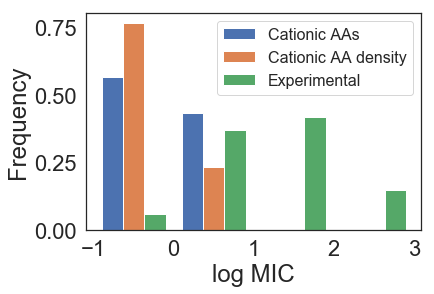

In [64]:
mic_labels = ['Cationic AAs','Cationic AA density','Experimental']
plt.hist([charge_constraint_pred_log_mic,charge_density_constraint_pred_log_mic,experimental_mic],normed=1,label=mic_labels,bins=range(-1,4))
plt.xlabel('log MIC')
plt.ylabel('Frequency')
plt.xticks(range(-1,4))
plt.legend(prop={'size':16})
plt.savefig('Figures_and_CNN_predictions/log_MIC_hist.png',bbox_inches='tight',frameon=False)
plt.show()

In [ ]:
dataset_hmoments = [hmoment_analysis(seq) for seq in ecoli_df.sequence]

In [ ]:
no_constraint_100 = [hmoments[1][0] for hmoments in no_constraint_hmoments]
charge_density_constraint_100 = [hmoments[1][0] for hmoments in charge_density_constraint_hmoments]
charge_constraint_100 = [hmoments[1][0] for hmoments in charge_constraint_hmoments]
dataset_100 = [hmoments[1][0] for hmoments in dataset_hmoments]

no_constraint_140 = [hmoments[1][1] for hmoments in no_constraint_hmoments]
charge_density_constraint_140 = [hmoments[1][1] for hmoments in charge_density_constraint_hmoments]
charge_constraint_140 = [hmoments[1][1] for hmoments in charge_constraint_hmoments]
dataset_140 = [hmoments[1][1] for hmoments in dataset_hmoments]

no_constraint_180 = [hmoments[1][3] for hmoments in no_constraint_hmoments]
charge_density_constraint_180 = [hmoments[1][3] for hmoments in charge_density_constraint_hmoments]
charge_constraint_180 = [hmoments[1][3] for hmoments in charge_constraint_hmoments]
dataset_180 = [hmoments[1][3] for hmoments in dataset_hmoments]

In [ ]:
hmoment_labels = ['Cationic AAs','Cationic AA density','Experimental']

plt.hist([charge_density_constraint_100,charge_constraint_100,dataset_100],bins=10,normed=1,label=hmoment_labels)
# plt.hist(,bins=20)
plt.xlabel('HM percentile for alpha helix',fontsize=16)
plt.ylabel('Frequency',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks([0.02*i for i in range(5)],fontsize=16)
plt.legend()
plt.legend(loc='upper left',prop={'size':16})
plt.savefig('Figures_and_CNN_predictions/alpha_helix_hmoment.png',bbox_inches='tight',frameon=False)
# plt.ylabel('')
plt.show()

plt.hist([charge_density_constraint_140,charge_constraint_140,dataset_140],bins=10,normed=1,label=hmoment_labels)
# plt.hist(,bins=20)
plt.xlabel('HM percentile for $140^\circ$ rotation',fontsize=16)
plt.yticks([0.01*i for i in range(4)],fontsize=16)
plt.ylabel('Frequency',fontsize=16)
plt.xticks(fontsize=16)
plt.legend()
plt.legend(loc='best',prop={'size':14})
plt.savefig('Figures_and_CNN_predictions/140_degree_hmoment.png',bbox_inches='tight',frameon=False)
# plt.ylabel('Count')
plt.show()

plt.hist([charge_density_constraint_180,charge_constraint_180,dataset_180],bins=10,normed=1,label=hmoment_labels)
# plt.hist(,bins=20)
plt.xlabel('HM percentile for beta sheet',fontsize=16)
plt.yticks([0.01*i for i in range(5)],fontsize=16)
plt.xticks(fontsize=16)
plt.legend()
plt.legend(loc='upper left',prop={'size':14})
plt.savefig('Figures_and_CNN_predictions/beta_sheet_hmoment.png',bbox_inches='tight',frameon=False)
# plt.ylabel('Count')
plt.show()

# plt.hist(all_peptide_df['100_hmoment'],bins=20)
# plt.xlabel('HM for alpha helix')
# plt.ylabel('Count')
# plt.show()
# plt.hist(all_peptide_df['Pred_log_MIC'],bins=20)
# plt.xlabel('Predicted log MIC')
# plt.ylabel('Count')
# plt.show()

In [ ]:
plt.hist([no_constraint_100,charge_density_constraint_100,charge_constraint_100],bins=10)
plt.xlabel('HM percentile for alpha helix')
plt.ylabel('Count')
plt.show()

## Looking at best alignments for peptides of interest

In [ ]:
# good_seqs = ['GWKVWKKILAKLAKLAK','WRRWWKILKAALAKLAK','WRWWKILKKLATVLKKLITLGTLA']
# good_seqs = good_seqs + ['RRWKWRKLAKVLTTLLRGGKRIQRL','WRKFWKKILKKLAKLAKTGLRKPII','GWRWWKKLAKVLAKLAK']
# good_seqs = ['WRKFLLKILKLLVQRYR','KWKKFWKVLKKVF']
# good_seqs = ['RRWKWRKLAKVLTTLLRGGKRIQRL','WRRWWKILKAALAKLAK','WRRWWKILKAALAKLAK','RKWIWWKLAKVLAKLAK','GFWKKILKKLATKLAKLAK']
good_seqs = ['RKWIWWKLAKVLAKLAK','GFWKKILKKLATKLAKLAK','GWKTLAKLAKKLAKLAK','WRKFWKKILKKLAKLAKTGLRKPII']
for seq in good_seqs:
    print all_peptide_df.loc[all_peptide_df.Sequence.str.contains(seq)]['Best_match']

In [ ]:
print all_peptide_df.loc[all_peptide_df.Sequence.str.contains('DAHKLAKLAKKLAKLAK')]

In [ ]:
# seq_matches = ['VNWKKILAKIIKVAK','KWWRWRRWW','KWKSFIKKLTSVLKKVVTTAKPLISS','FKCWRWQWRWKKLGAKVFKRLEKLFSKI','KWKKLLKKLLKLPKKLLKKLKKLLK','FKCWRWQWRWKKLGAKVFKRLEKLFSKI']
# seq_matches = ['KWKKLLKKLLKLL','KWKKFKKIGAVLKKL']
# seq_matches = ['FKCWRWQWRWKKLGAKVFKRLEKLFSKI','KWWRWRRWW','DAHKLAKLAKKLAKLAK']
seq_matches=['DAHKLAKLAKKLAKLAK','DAHKLAKLAKKLAKLAK','DAHKLAKLAKKLAKLAK','KWKKLLKKLLKLPKKLLKKLKKLLK']
for index,my_seq in enumerate(good_seqs):
    their_seq = seq_matches[index]
#     print df.loc[df.sequence.str.contains('KWKSFIKKLTSVLKKVVTTAKPLISS')]
    print 'Pam30 matrix:'
    alignment=pairwise2.align.localds(my_seq,their_seq,matlist.pam30,-9,-1)
    print pairwise2.format_alignment(*alignment[0])
#     print 'Identity matrix:'
#     alignment=pairwise2.align.localds(my_seq,their_seq,matlist.ident,-9,-1)
#     print pairwise2.format_alignment(*alignment[0])

# Generate fasta files with test sets for all data, 90% and 70% identity

## First generate training and test set fasta files, and assemble the training ensemble model

In [86]:
all_sequences=[sequence for sequence in ecoli_df.sequence]
ENSEMBLE_SIZE=5
NEG_RATIOS = [1,3,10]
with_C_weights = []
with_C_architectures = []
no_C_weights = []
no_C_architectures = []
for k in range(len(NEG_RATIOS)):
    with_C_weights.append(['train_ensemble_weights_withC_'+repr(NEG_RATIOS[k])+'xneg_'+repr(i)+'.h5' for i in range(ENSEMBLE_SIZE)])
    with_C_architectures.append(['train_ensemble_architecture_withC_'+repr(NEG_RATIOS[k])+'xneg_'+repr(i)+'.json' for i in range(ENSEMBLE_SIZE)])
    no_C_weights.append(['train_ensemble_weights_noC_'+repr(NEG_RATIOS[k])+'xneg_'+repr(i)+'.h5' for i in range(ENSEMBLE_SIZE)])
    no_C_architectures.append(['train_ensemble_architecture_noC_'+repr(NEG_RATIOS[k])+'xneg_'+repr(i)+'.json' for i in range(ENSEMBLE_SIZE)])

    
with_c_ensembles = [[] for i in range(len(NEG_RATIOS))]
no_c_ensembles = [[] for i in range(len(NEG_RATIOS))]
for k in range(len(NEG_RATIOS)):
    for i in range(len(with_C_weights[0])):
        with open('models/Saved_models_training_data_only/'+with_C_architectures[k][i],'r') as f:
            reconst_model = model_from_json(f.read())
        reconst_model.load_weights('models/Saved_models_training_data_only/'+with_C_weights[k][i])
        reconst_model.compile(loss='mean_squared_error',optimizer='adam')
        with_c_ensembles[k].append(reconst_model)    

        with open('models/Saved_models_training_data_only/'+no_C_architectures[k][i],'r') as f:
            reconst_model = model_from_json(f.read())
        reconst_model.load_weights('models/Saved_models_training_data_only/'+no_C_weights[k][i])
        reconst_model.compile(loss='mean_squared_error',optimizer='adam')
        no_c_ensembles[k].append(reconst_model)
        
# everything_ensemble_model = EnsembleModel(no_c_ensembles[0]+with_c_ensembles[0]+no_c_ensembles[1]+with_c_ensembles[1]+no_c_ensembles[2]+with_c_ensembles[2],'average')  

In [87]:
no_c_ensemble_models = [EnsembleModel(no_c_ensembles[k],'classify_then_average') for k in range(len(NEG_RATIOS))]
with_c_ensemble_models = [EnsembleModel(with_c_ensembles[k],'classify_then_average') for k in range(len(NEG_RATIOS))]
no_c_ensemble_model_avgs = [EnsembleModel(no_c_ensembles[k],'average') for k in range(len(NEG_RATIOS))]
with_c_ensemble_model_avgs = [EnsembleModel(with_c_ensembles[k],'average') for k in range(len(NEG_RATIOS))]
all_ensemble_models = [EnsembleModel(no_c_ensembles[k]+with_c_ensembles[k],'classify_then_average') for k in range(len(NEG_RATIOS))]
all_ensemble_model_avgs = [EnsembleModel(no_c_ensembles[k]+with_c_ensembles[k],'average') for k in range(len(NEG_RATIOS))]

everything_ensemble_model = EnsembleModel(no_c_ensembles[0]+with_c_ensembles[0]+no_c_ensembles[1]+with_c_ensembles[1]+no_c_ensembles[2]+with_c_ensembles[2],'classify_then_average')  
everything_ensemble_model_avg = EnsembleModel(no_c_ensembles[0]+with_c_ensembles[0]+no_c_ensembles[1]+with_c_ensembles[1]+no_c_ensembles[2]+with_c_ensembles[2],'average')

ensemble_model_list = no_c_ensemble_models+with_c_ensemble_models+[everything_ensemble_model]
ensemble_model_list_avgs = no_c_ensemble_model_avgs + with_c_ensemble_model_avgs + [everything_ensemble_model_avg]

In [88]:
train_fasta = seqs_to_fasta(ecoli_train_with_c['sequence'])
test_fasta = seqs_to_fasta(ecoli_test['sequence'])

In [90]:
train_file = open('data/Fasta_files/train_fasta.txt','w')
train_file.write(train_fasta)
train_file.close()
test_file = open('data/Fasta_files/test_fasta.txt','w')
test_file.write(test_fasta)
test_file.close()

## Now remove sequences at http://weizhong-lab.ucsd.edu/cdhit-web-server/cgi-bin/index.cgi?cmd=cd-hit-2d

### Sequence identity cutoffs to run with: 0.9 and 0.7

### In all other settings: just use the defaults

### Then make a file containing the sequences along with the predictions from the various ensembles

In [91]:
indices = []
for i,seq in enumerate(ecoli_test['sequence']):
    if len(seq)<MAX_SEQUENCE_LENGTH:
        indices.append(i)
ecoli_test_not_too_long = ecoli_test.iloc[indices].reset_index(drop=True)

In [92]:
indices = []
for i,seq in enumerate(ecoli_test['sequence']):
    if seq in seqs_p9_cutoff and len(seq)<MAX_SEQUENCE_LENGTH:
        indices.append(i)
ecoli_test_p9 = ecoli_test.iloc[indices]

indices = []
for i,seq in enumerate(ecoli_test['sequence']):
    if seq in seqs_p7_cutoff and len(seq)<MAX_SEQUENCE_LENGTH:
        indices.append(i)
ecoli_test_p7 = ecoli_test.iloc[indices]

In [93]:
seqs = ecoli_df.sequence
lengths = [min(MAX_SEQUENCE_LENGTH,len(seq)) for seq in seqs]
SEQ_LENGTHS = lengths
ecoli_test_input = df_to_input_vec(ecoli_test)
ecoli_test_input_with_negatives = add_random_negative_examples(ecoli_test_input[0],ecoli_test_input[1],ecoli_test_input[2],ratio=1,max_mic=MAX_MIC,include_cysteine=False)
ecoli_test_input_p9 = df_to_input_vec(ecoli_test_p9)
ecoli_test_input_with_negatives_p9 = add_random_negative_examples(ecoli_test_input_p9[0],ecoli_test_input_p9[1],ecoli_test_input_p9[2],ratio=1,max_mic=MAX_MIC,include_cysteine=False)
ecoli_test_input_p7 = df_to_input_vec(ecoli_test_p7)
ecoli_test_input_with_negatives_p7 = add_random_negative_examples(ecoli_test_input_p7[0],ecoli_test_input_p7[1],ecoli_test_input_p7[2],ratio=1,max_mic=MAX_MIC,include_cysteine=False)


test_x_with_negatives = ecoli_test_input_with_negatives[0]
test_y_with_negatives = ecoli_test_input_with_negatives[1]
test_x_p9_with_negatives = ecoli_test_input_with_negatives_p9[0]
test_y_p9_with_negatives = ecoli_test_input_with_negatives_p9[1]
test_x_p7_with_negatives = ecoli_test_input_with_negatives_p7[0]
test_y_p7_with_negatives = ecoli_test_input_with_negatives_p7[1]

ecoli_test_input = df_to_input_vec(ecoli_test_not_too_long)
test_x = ecoli_test_input[0]
test_y = ecoli_test_input[1]
test_x_p9 = ecoli_test_input_p9[0]
test_y_p9 = ecoli_test_input_p9[1]
test_x_p7 = ecoli_test_input_p7[0]
test_y_p7 = ecoli_test_input_p7[1]

# Testing model preformance

## First assemble decoy data

In [120]:
all_decoys = []
# fnames = ['Veltri_data/DECOY.eval.fa','Veltri_data/DECOY.te.fa','Veltri_data/DECOY.tr.fa']
fnames = ['data/Fasta_files/Uniprot_negatives.txt']
for fname in fnames:
    fasta_sequences=SeqIO.parse(fname,'fasta')
    for fasta in fasta_sequences:
        seq = str(fasta.seq)
        all_decoys.append(seq)
print len(all_decoys)
decoys_no_cysteine = []
for seq in all_decoys:
    if len(seq)>MAX_SEQUENCE_LENGTH:
        tries=0
        added = False
        while tries<15 and not added:
            start = random.randint(0,len(seq)-MAX_SEQUENCE_LENGTH)
            to_add = seq[start:(start+MAX_SEQUENCE_LENGTH)]
            tries += 1
            if 'C' not in to_add:
                decoys_no_cysteine.append(to_add)
                added = True
decoy_set = set(decoys_no_cysteine)

6329


In [121]:
def uniprot_testing_set(seqs,yvals,decoy_set,include_cysteine = True):
    deep_decoy_set = deepcopy(decoy_set)
#     print len(deep_decoy_set)
    lengths = []
    output_pos_seqs = []
    output_pos_yvals = []
    output_neg_seqs = []
    output_neg_yvals = []
    for i,seq in enumerate(seqs):
        if len(seq)<MAX_SEQUENCE_LENGTH:
            output_pos_seqs.append(seq)
            output_pos_yvals.append(yvals[i])
            output_neg_yvals.append(MAX_MIC)
#             print i
#             done = False
            alt_seq = ''
            for decoy_seq in deep_decoy_set:
#                 if len(decoy_seq) == len(seq):
#                     output_neg_seqs.append(decoy_seq)
#                     done = True
#                     deep_decoy_set.remove(decoy_seq)
#                     break
                if len(decoy_seq) >= len(seq):
                    alt_seq = decoy_seq
                    break
#             if not done:
            start = random.randint(0,len(alt_seq)-len(seq))
            output_neg_seqs.append(alt_seq[start:(start+len(seq))])
            deep_decoy_set.remove(alt_seq)
                
    return output_pos_seqs, output_neg_seqs, output_pos_yvals, output_neg_yvals

def random_testing_set(seqs,yvals,include_cysteine = True,keep_maxlength_seqs=False):
    lengths = []
    output_pos_seqs = []
    output_pos_yvals = []
    output_neg_seqs = []
    output_neg_yvals = []
    for i,seq in enumerate(seqs):
        if len(seq)<MAX_SEQUENCE_LENGTH or keep_maxlength_seqs:
            output_pos_seqs.append(seq)
            output_pos_yvals.append(yvals[i])
            output_neg_yvals.append(MAX_MIC)
            output_neg_seqs.append(generate_random_sequence(list(CHARACTER_DICT),include_C=False,fixed_length=len(seq),just_seq=True))
                
    return output_pos_seqs, output_neg_seqs, output_pos_yvals, output_neg_yvals

In [122]:
seqs_p9_cutoff = fasta_to_seqs('data/Fasta_files/p9_identity.txt')
seqs_p7_cutoff = fasta_to_seqs('data/Fasta_files/p7_identity.txt')

In [123]:
seqs = ecoli_test.sequence
vals = ecoli_test.value
output_pos_seqs, output_neg_seqs, output_pos_yvals, output_neg_yvals = uniprot_testing_set(seqs,vals,decoy_set)
all_test_seqs = output_pos_seqs + output_neg_seqs
all_test_y_vals = output_pos_yvals + output_neg_yvals

p9_y_vals = []
p9_seqs = []
for i,seq in enumerate(seqs):
    if seq in seqs_p9_cutoff:
        p9_y_vals.append(vals[i])
        p9_seqs.append(seq)

p7_y_vals = []
p7_seqs = []
for i,seq in enumerate(seqs):
    if seq in seqs_p7_cutoff:
        p7_y_vals.append(vals[i])
        p7_seqs.append(seq)

In [124]:
output_pos_seqs_p9, output_neg_seqs_p9, output_pos_yvals_p9, output_neg_yvals_p9 = uniprot_testing_set(p9_seqs,p9_y_vals,decoy_set)
all_test_seqs_p9 = output_pos_seqs_p9 + output_neg_seqs_p9
all_test_y_vals_p9 = output_pos_yvals_p9 + output_neg_yvals_p9
# print len(all_test_seqs_p9)
# print len(output_pos_seqs_p9)

output_pos_seqs_p7, output_neg_seqs_p7, output_pos_yvals_p7, output_neg_yvals_p7 = uniprot_testing_set(p7_seqs,p7_y_vals,decoy_set)
all_test_seqs_p7 = output_pos_seqs_p7 + output_neg_seqs_p7
all_test_y_vals_p7 = output_pos_yvals_p7 + output_neg_yvals_p7
# print len(all_test_seqs_p7)
# print len(output_pos_seqs_p7)

In [125]:
vectors_with_uniprot = []
for i,seq in enumerate(all_test_seqs):
    vectors_with_uniprot.append(sequence_to_vector(seq,False))
vectors_with_uniprot = np.array(vectors_with_uniprot)

vectors_with_uniprot_p9 = []
for i,seq in enumerate(all_test_seqs_p9):
    vectors_with_uniprot_p9.append(sequence_to_vector(seq,False))
vectors_with_uniprot_p9 = np.array(vectors_with_uniprot_p9)

vectors_with_uniprot_p7 = []
for i,seq in enumerate(all_test_seqs_p7):
    vectors_with_uniprot_p7.append(sequence_to_vector(seq,False))
vectors_with_uniprot_p7 = np.array(vectors_with_uniprot_p7)

In [126]:
all_preds=[]
for emodel in ensemble_model_list:
    all_preds.append(emodel.predict(vectors_with_uniprot))
output_file = open('Figures_and_CNN_predictions/predictions_vs_uniprot.csv','w')
output_file.write('Sequence,Amidation,Actual,No_C_1,No_C_3,No_C_10,With_C_1,With_C_3,With_C_10,All\n')
for i,testx in enumerate(vectors_with_uniprot):
    amp = vector_to_amp(testx)
    output_file.write(repr(amp['sequence'])+','+repr(amp['cterminal_amidation'])+','+repr(all_test_y_vals[i])+',')
    for k in range(len(ensemble_model_list)):
#         print all_preds
        output_file.write(repr(all_preds[k][i])+',')
    output_file.write('\n')
output_file.close()
seqs_for_fasta = []
for vect in vectors_with_uniprot:
    seq = vector_to_amp(vect)['sequence']
    if seq.find('_')>-1:
        seq = seq[0:seq.find('_')]
    seqs_for_fasta.append(seq)
for_fasta = seqs_to_fasta(seqs_for_fasta)
test_file = open('data/Fasta_files/test_fasta_with_negatives_vs_uniprot.txt','w')
test_file.write(for_fasta)
test_file.close()

In [127]:
all_preds=[]
for emodel in ensemble_model_list_avgs:
    all_preds.append(emodel.predict(vectors_with_uniprot))
output_file = open('Figures_and_CNN_predictions/predictions_vs_uniprot_avgs.csv','w')
output_file.write('Sequence,Amidation,Actual,No_C_1,No_C_3,No_C_10,With_C_1,With_C_3,With_C_10,All\n')
for i,testx in enumerate(vectors_with_uniprot):
    amp = vector_to_amp(testx)
    output_file.write(repr(amp['sequence'])+','+repr(amp['cterminal_amidation'])+','+repr(all_test_y_vals[i])+',')
    for k in range(len(ensemble_model_list)):
#         print all_preds
        output_file.write(repr(all_preds[k][i])+',')
    output_file.write('\n')
output_file.close()

all_preds=[]
for emodel in ensemble_model_list:
    all_preds.append(emodel.predict(vectors_with_uniprot_p9))
output_file_p9 = open('Figures_and_CNN_predictions/predictions_vs_uniprot_p9.csv','w')
output_file_p9.write('Sequence,Amidation,Actual,No_C_1,No_C_3,No_C_10,With_C_1,With_C_3,With_C_10,All\n')
for i,testx in enumerate(vectors_with_uniprot_p9):
    amp = vector_to_amp(testx)
    output_file_p9.write(repr(amp['sequence'])+','+repr(amp['cterminal_amidation'])+','+repr(all_test_y_vals_p9[i])+',')
    for k in range(len(ensemble_model_list)):
#         print all_preds
        output_file_p9.write(repr(all_preds[k][i])+',')
    output_file_p9.write('\n')
output_file_p9.close()

In [129]:
seqs_for_fasta = []
for vect in vectors_with_uniprot_p9:
    seq = vector_to_amp(vect)['sequence']
    if seq.find('_')>-1:
        seq = seq[0:seq.find('_')]
    seqs_for_fasta.append(seq)
for_fasta = seqs_to_fasta(seqs_for_fasta)
test_file = open('data/Fasta_files/test_fasta_with_negatives_vs_uniprot_p9.txt','w')
test_file.write(for_fasta)
test_file.close()

all_preds=[]
for emodel in ensemble_model_list:
    all_preds.append(emodel.predict(vectors_with_uniprot_p7))
output_file_p7 = open('Figures_and_CNN_predictions/predictions_vs_uniprot_p7.csv','w')
output_file_p7.write('Sequence,Amidation,Actual,No_C_1,No_C_3,No_C_10,With_C_1,With_C_3,With_C_10,All\n')
for i,testx in enumerate(vectors_with_uniprot_p7):
    amp = vector_to_amp(testx)
    output_file_p7.write(repr(amp['sequence'])+','+repr(amp['cterminal_amidation'])+','+repr(all_test_y_vals_p7[i])+',')
    for k in range(len(ensemble_model_list)):
#         print all_preds
        output_file_p7.write(repr(all_preds[k][i])+',')
    output_file_p7.write('\n')
output_file_p7.close()

seqs_for_fasta = []
for vect in vectors_with_uniprot_p7:
    seq = vector_to_amp(vect)['sequence']
    if seq.find('_')>-1:
        seq = seq[0:seq.find('_')]
    seqs_for_fasta.append(seq)
for_fasta = seqs_to_fasta(seqs_for_fasta)
test_file = open('data/Fasta_files/test_fasta_with_negatives_vs_uniprot_p7.txt','w')
test_file.write(for_fasta)
test_file.close()

In [130]:
all_preds=[]
for emodel in ensemble_model_list_avgs:
    all_preds.append(emodel.predict(vectors_with_uniprot_p9))
output_file = open('Figures_and_CNN_predictions/predictions_vs_uniprot_p9_avgs.csv','w')
output_file.write('Sequence,Amidation,Actual,No_C_1,No_C_3,No_C_10,With_C_1,With_C_3,With_C_10,All\n')
for i,testx in enumerate(vectors_with_uniprot_p9):
    amp = vector_to_amp(testx)
    output_file.write(repr(amp['sequence'])+','+repr(amp['cterminal_amidation'])+','+repr(all_test_y_vals[i])+',')
    for k in range(len(ensemble_model_list)):
#         print all_preds
        output_file.write(repr(all_preds[k][i])+',')
    output_file.write('\n')
output_file.close()

all_preds=[]
for emodel in ensemble_model_list_avgs:
    all_preds.append(emodel.predict(vectors_with_random_p9))
output_file = open('Figures_and_CNN_predictions/predictions_vs_random_p9_avgs.csv','w')
output_file.write('Sequence,Amidation,Actual,No_C_1,No_C_3,No_C_10,With_C_1,With_C_3,With_C_10,All\n')
for i,testx in enumerate(vectors_with_random_p9):
    amp = vector_to_amp(testx)
    output_file.write(repr(amp['sequence'])+','+repr(amp['cterminal_amidation'])+','+repr(all_test_y_vals[i])+',')
    for k in range(len(ensemble_model_list)):
#         print all_preds
        output_file.write(repr(all_preds[k][i])+',')
    output_file.write('\n')
output_file.close()

In [151]:
all_preds=[]
for emodel in ensemble_model_list_avgs:
    all_preds.append(emodel.predict(vectors_with_uniprot_p7))
output_file = open('Figures_and_CNN_predictions/predictions_vs_uniprot_p7_avgs.csv','w')
output_file.write('Sequence,Amidation,Actual,No_C_1,No_C_3,No_C_10,With_C_1,With_C_3,With_C_10,All\n')
for i, testx in enumerate(vectors_with_uniprot_p7):
    amp = vector_to_amp(testx)
    output_file.write(repr(amp['sequence'])+','+repr(amp['cterminal_amidation'])+','+repr(all_test_y_vals[i])+',')
    for k in range(len(ensemble_model_list)):
#         print all_preds
        output_file.write(repr(all_preds[k][i])+',')
    output_file.write('\n')
output_file.close()

all_preds=[]
for emodel in ensemble_model_list_avgs:
    all_preds.append(emodel.predict(vectors_with_random_p7))
output_file = open('Figures_and_CNN_predictions/predictions_vs_random_p7_avgs.csv','w')
output_file.write('Sequence,Amidation,Actual,No_C_1,No_C_3,No_C_10,With_C_1,With_C_3,With_C_10,All\n')
for i,testx in enumerate(vectors_with_random_p7):
    amp = vector_to_amp(testx)
    output_file.write(repr(amp['sequence'])+','+repr(amp['cterminal_amidation'])+','+repr(all_test_y_vals[i])+',')
    for k in range(len(ensemble_model_list)):
#         print all_preds
        output_file.write(repr(all_preds[k][i])+',')
    output_file.write('\n')
output_file.close()

In [152]:
seqs = ecoli_test.sequence
vals = ecoli_test.value
output_pos_seqs, output_neg_seqs, output_pos_yvals, output_neg_yvals = random_testing_set(seqs,vals)
all_test_seqs = output_pos_seqs + output_neg_seqs
all_test_y_vals = output_pos_yvals + output_neg_yvals

p9_y_vals = []
p9_seqs = []
for i,seq in enumerate(seqs):
    if seq in seqs_p9_cutoff:
        p9_y_vals.append(vals[i])
        p9_seqs.append(seq)

p7_y_vals = []
p7_seqs = []
for i,seq in enumerate(seqs):
    if seq in seqs_p7_cutoff:
        p7_y_vals.append(vals[i])
        p7_seqs.append(seq)

output_pos_seqs_p9, output_neg_seqs_p9, output_pos_yvals_p9, output_neg_yvals_p9 = random_testing_set(p9_seqs,p9_y_vals)
all_test_seqs_p9 = output_pos_seqs_p9 + output_neg_seqs_p9
all_test_y_vals_p9 = output_pos_yvals_p9 + output_neg_yvals_p9
# print len(all_test_seqs_p9)
# print len(output_pos_seqs_p9)

output_pos_seqs_p7, output_neg_seqs_p7, output_pos_yvals_p7, output_neg_yvals_p7 = random_testing_set(p7_seqs,p7_y_vals)
all_test_seqs_p7 = output_pos_seqs_p7 + output_neg_seqs_p7
all_test_y_vals_p7 = output_pos_yvals_p7 + output_neg_yvals_p7
# print len(all_test_seqs_p7)
# print len(output_pos_seqs_p7)

In [153]:
vectors_with_random = []
for i,seq in enumerate(all_test_seqs):
    vectors_with_random.append(sequence_to_vector(seq,False))
vectors_with_random = np.array(vectors_with_random)

vectors_with_random_p9 = []
for i,seq in enumerate(all_test_seqs_p9):
    vectors_with_random_p9.append(sequence_to_vector(seq,False))
vectors_with_random_p9 = np.array(vectors_with_random_p9)

vectors_with_random_p7 = []
for i,seq in enumerate(all_test_seqs_p7):
    vectors_with_random_p7.append(sequence_to_vector(seq,False))
vectors_with_random_p7 = np.array(vectors_with_random_p7)

In [155]:
all_preds=[]
for emodel in ensemble_model_list:
    all_preds.append(emodel.predict(vectors_with_random))
output_file = open('Figures_and_CNN_predictions/predictions_vs_random.csv','w')
output_file.write('Sequence,Amidation,Actual,No_C_1,No_C_3,No_C_10,With_C_1,With_C_3,With_C_10,All\n')
for i,testx in enumerate(vectors_with_random):
    amp = vector_to_amp(testx)
    output_file.write(repr(amp['sequence'])+','+repr(amp['cterminal_amidation'])+','+repr(all_test_y_vals[i])+',')
    for k in range(len(ensemble_model_list)):
#         print all_preds
        output_file.write(repr(all_preds[k][i])+',')
    output_file.write('\n')
output_file.close()
seqs_for_fasta = []
for vect in vectors_with_random:
    seq = vector_to_amp(vect)['sequence']
    if seq.find('_')>-1:
        seq = seq[0:seq.find('_')]
    seqs_for_fasta.append(seq)
for_fasta = seqs_to_fasta(seqs_for_fasta)
test_file = open('data/Fasta_files/test_fasta_with_negatives_vs_random.txt','w')
test_file.write(for_fasta)
test_file.close()

In [156]:
all_preds=[]
for emodel in ensemble_model_list_avgs:
    all_preds.append(emodel.predict(vectors_with_random))
output_file = open('Figures_and_CNN_predictions/predictions_vs_random_avgs.csv','w')
output_file.write('Sequence,Amidation,Actual,No_C_1,No_C_3,No_C_10,With_C_1,With_C_3,With_C_10,All\n')
for i,testx in enumerate(vectors_with_random):
    amp = vector_to_amp(testx)
    output_file.write(repr(amp['sequence'])+','+repr(amp['cterminal_amidation'])+','+repr(all_test_y_vals[i])+',')
    for k in range(len(ensemble_model_list)):
#         print all_preds
        output_file.write(repr(all_preds[k][i])+',')
    output_file.write('\n')
output_file.close()

In [158]:
all_preds=[]
for emodel in ensemble_model_list:
    all_preds.append(emodel.predict(vectors_with_random_p9))
output_file_p9 = open('Figures_and_CNN_predictions/predictions_vs_random_p9.csv','w')
output_file_p9.write('Sequence,Amidation,Actual,No_C_1,No_C_3,No_C_10,With_C_1,With_C_3,With_C_10,All\n')
for i,testx in enumerate(vectors_with_random_p9):
    amp = vector_to_amp(testx)
    output_file_p9.write(repr(amp['sequence'])+','+repr(amp['cterminal_amidation'])+','+repr(all_test_y_vals_p9[i])+',')
    for k in range(len(ensemble_model_list)):
#         print all_preds
        output_file_p9.write(repr(all_preds[k][i])+',')
    output_file_p9.write('\n')
output_file_p9.close()

seqs_for_fasta = []
for vect in vectors_with_random_p9:
    seq = vector_to_amp(vect)['sequence']
    if seq.find('_')>-1:
        seq = seq[0:seq.find('_')]
    seqs_for_fasta.append(seq)
for_fasta = seqs_to_fasta(seqs_for_fasta)
test_file = open('data/Fasta_files/test_fasta_with_negatives_vs_random_p9.txt','w')
test_file.write(for_fasta)
test_file.close()

all_preds=[]
for emodel in ensemble_model_list:
    all_preds.append(emodel.predict(vectors_with_random_p7))
output_file_p7 = open('Figures_and_CNN_predictions/predictions_vs_random_p7.csv','w')
output_file_p7.write('Sequence,Amidation,Actual,No_C_1,No_C_3,No_C_10,With_C_1,With_C_3,With_C_10,All\n')
for i,testx in enumerate(vectors_with_random_p7):
    amp = vector_to_amp(testx)
    output_file_p7.write(repr(amp['sequence'])+','+repr(amp['cterminal_amidation'])+','+repr(all_test_y_vals_p7[i])+',')
    for k in range(len(ensemble_model_list)):
#         print all_preds
        output_file_p7.write(repr(all_preds[k][i])+',')
    output_file_p7.write('\n')
output_file_p7.close()

seqs_for_fasta = []
for vect in vectors_with_random_p7:
    seq = vector_to_amp(vect)['sequence']
    if seq.find('_')>-1:
        seq = seq[0:seq.find('_')]
    seqs_for_fasta.append(seq)
for_fasta = seqs_to_fasta(seqs_for_fasta)
test_file = open('data/Fasta_files/test_fasta_with_negatives_vs_random_p7.txt','w')
test_file.write(for_fasta)
test_file.close()

# kNN and OCNN (one-class nearest neighbors) based classification (OCNN performed worse and we didn't include it in the paper)

In [159]:
from sklearn.metrics import matthews_corrcoef

In [160]:
ecoli_train_train_no_c = pd.read_pickle('models/Saved_variables/ecoli_train_train_no_c_df.pkl')
ecoli_validate_no_c = pd.read_pickle('models/Saved_variables/ecoli_validate_no_c_df.pkl')

In [161]:
def levenshtein(s1, s2):
    if len(s1) < len(s2):
        return levenshtein(s2, s1)

    # len(s1) >= len(s2)
    if len(s2) == 0:
        return len(s1)

    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1 # j+1 instead of j since previous_row and current_row are one character longer
            deletions = current_row[j] + 1       # than s2
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    
    return previous_row[-1]

def nn_distance(seq,seq_db):
    min_dist = 100
    for seq_in_db in seq_db:
        dist = levenshtein(seq,seq_in_db)
        min_dist = min(dist,min_dist)
    return min_dist

def knn_distances(seq, seq_db, k):
    distances = [levenshtein(seq, seq_in_db) for seq_in_db in seq_db]
    return sorted(distances)[:k]

def avg_knn_distance(seq,seq_db,k):
    return np.mean(knn_distances(seq,seq_db,k))

def kjnn_distance_ratio(seq,seq_db,j,k):
    min_dists = [100]*j
    min_dist_seqs = [' ']*j
    for i,seq_in_db in enumerate(seq_db):
        dist = levenshtein(seq,seq_in_db)
        for ind,min_dist in enumerate(min_dists):
            if dist<min_dist:
                min_dists[ind]=dist
                min_dist_seqs[ind]=seq_in_db
                break
    second_neighbor_dists = []
    for second_seq in min_dist_seqs:
        second_neighbor_dists.append(avg_knn_distance(second_seq,seq_db,k+1)*float(k+1)/float(k))
    return np.mean(min_dists),np.mean(second_neighbor_dists),np.mean(min_dists)/np.mean(second_neighbor_dists)

def knn_all_distances_with_negatives(query_seqs,pos_seq_db,neg_seq_db,kmax):
    pos_distances = [knn_distances(seq,pos_seq_db,k) for seq in query_seqs]
    neg_distances = [knn_distances(seq,neg_seq_db,k) for seq in query_seqs]
    return pos_distances,neg_distances

def vote_fractions_by_k(pos_distances,neg_distances,kmax):
    to_return=[]
    for k in range(1,kmax+1):
        kfrac=0.
        pos_ind_on=0
        neg_ind_on=0
        for i in range(0,k):
            if pos_distances[pos_ind_on]<neg_distances[neg_ind_on]:
                pos_ind_on +=1
                kfrac += 1.0/k
            else:
                neg_ind_on += 1
        to_return.append(kfrac)
    return to_return

def vote_fraction(seq,pos_seq_db,neg_seq_db,k):
    pos_distances = knn_distances(seq,pos_seq_db,k)
    neg_distances = knn_distances(seq,neg_seq_db,k)
    frac=0.
    pos_ind_on=0
    neg_ind_on=0
    for i in range(0,k):
        if pos_distances[pos_ind_on]<neg_distances[neg_ind_on]:
            pos_ind_on +=1
            frac += 1.0/k
        else:
            neg_ind_on += 1
    return frac

def vote_fractions_matrix(all_distances_to_pos,all_distances_to_neg,kmax):
    return [vote_fractions_by_k(all_distances_to_pos[i],all_distances_to_neg[i],kmax) for i in range(len(all_distances_to_pos))]
    
def mcc_matrix(vote_fracs_pos_queries,vote_fracs_neg_queries,vote_cutoffs=[0.05+0.05*i for i in range(20)]):
    mat_to_return = [[0]*len(vote_cutoffs) for i in range(len(vote_fracs_pos_queries[0]))]
    print 'mat size: '+repr(len(mat_to_return))+' x '+repr(len(mat_to_return[0]))
    y_real=[1]*len(vote_fracs_pos_queries)+[0]*len(vote_fracs_neg_queries)
    for k_ind in range(len(vote_fracs_pos_queries[0])):
        for cutoff_ind,cutoff in enumerate(vote_cutoffs):
            y_pred=[]
            for row in vote_fracs_pos_queries:
                if row[k_ind]>cutoff:
                    y_pred.append(1)
                else:
                    y_pred.append(0)
            for row in vote_fracs_neg_queries:
                if row[k_ind]>cutoff:
                    y_pred.append(1)
                else:
                    y_pred.append(0)
            mat_to_return[k_ind][cutoff_ind]=matthews_corrcoef(y_real,y_pred)
    return mat_to_return

In [162]:
seqs = ecoli_validate_no_c.reset_index(drop=True).sequence
vals = ecoli_validate_no_c.reset_index(drop=True).value
nn_seq_db = ecoli_train_train_no_c.reset_index(drop=True).sequence
# output_pos_seqs, output_neg_seqs, output_pos_yvals, output_neg_yvals = random_testing_set(seqs,vals)

In [163]:
train_seqs = ecoli_train_train_no_c.reset_index(drop=True).sequence
train_vals = ecoli_train_train_no_c.reset_index(drop=True).value
# train_pos_seqs, train_neg_seqs, train_pos_yvals, train_neg_yvals = random_testing_set(train_seqs,train_vals,keep_maxlength_seqs=True)

In [164]:
# all_train_seqs = ecoli_train_no_c.reset_index(drop=True).sequence
# all_train_vals = ecoli_train_no_c.reset_index(drop=True).value
# train_pos_seqs, train_neg_seqs, train_pos_yvals, train_neg_yvals = random_testing_set(train_seqs,train_vals,keep_maxlength_seqs=True)

In [166]:
train_seq_db = ecoli_train_with_c.reset_index(drop=True).sequence
train_vals=ecoli_train_with_c.reset_index(drop=True).value
train_pos_seqs, train_neg_seqs, train_pos_yvals, train_neg_yvals = random_testing_set(train_seq_db,train_vals,keep_maxlength_seqs=True)
train_negs_file = open('data/Fasta_files/ocnn_train_negs.txt','w')
train_negs_file.write(seqs_to_fasta(train_neg_seqs))
train_negs_file.close()

In [167]:
train_negs_file = open('data/Fasta_files/ocnn_tuning_negs.txt','w')
train_negs_file.write(seqs_to_fasta(train_neg_seqs))
train_negs_file.close()
train_negs_file = open('data/Fasta_files/ocnn_validation_negs.txt','w')
train_negs_file.write(seqs_to_fasta(output_neg_seqs))
train_negs_file.close()

In [168]:
knn_distances_with_negatives_for_pos_seqs = knn_all_distances_with_negatives(output_pos_seqs,train_pos_seqs,train_neg_seqs,10)
knn_distances_with_negatives_for_neg_seqs = knn_all_distances_with_negatives(output_neg_seqs,train_pos_seqs,train_neg_seqs,10)

KeyboardInterrupt: 

In [ ]:
knn_to_pos_for_pos=knn_distances_with_negatives_for_pos_seqs[0]
knn_to_neg_for_pos=knn_distances_with_negatives_for_pos_seqs[1]
knn_to_pos_for_neg=knn_distances_with_negatives_for_neg_seqs[0]
knn_to_neg_for_neg=knn_distances_with_negatives_for_neg_seqs[1]

In [ ]:
vote_frac_matrix_pos_queries=vote_fractions_matrix(knn_to_pos_for_pos,knn_to_neg_for_pos,10)
vote_frac_matrix_neg_queries=vote_fractions_matrix(knn_to_pos_for_neg,knn_to_neg_for_neg,10)

In [ ]:
mcc_mat = mcc_matrix(vote_frac_matrix_pos_queries,vote_frac_matrix_neg_queries)

In [ ]:
for row in mcc_mat:
    print row

In [ ]:
pos_dists = []
for seq in output_pos_seqs:
    pos_dists.append(nn_distance(seq,nn_seq_db))

In [ ]:
neg_dists = []
for seq in output_neg_seqs:
    neg_dists.append(nn_distance(seq,nn_seq_db))

In [ ]:
output_file = open('Figures_and_CNN_predictions/ocnn_validation_distances.csv','w')
output_file.write('Sequence,Is_AMP,Min_distance\n')
for i,seq in enumerate(output_pos_seqs):
    output_file.write(seq+',1,'+repr(pos_dists[i])+'\n')
for i,seq in enumerate(output_neg_seqs):
    output_file.write(seq+',0,'+repr(neg_dists[i])+'\n')
output_file.close()

In [ ]:
# Compute MCC as a function of just nearest neighbor distances (a simper version, basically a KNN approach as opposed to a JKNN approach)
distance_cutoffs = [i+0.5 for i in range(30)]
actual_y = [1]*len(pos_dists)+[0]*len(neg_dists)
for cutoff in distance_cutoffs:
    pred_y = []
    for dist in pos_dists:
        dist=float(dist)
        if dist>cutoff:
            pred_y.append(0)
        else:
            pred_y.append(1)
    for dist in neg_dists:
        dist=float(dist)
        if dist>cutoff:
            pred_y.append(0)
        else:
            pred_y.append(1)
    print repr(cutoff)+','+repr(matthews_corrcoef(actual_y,pred_y))

In [ ]:
k=1
pos_dists = []
for seq in output_pos_seqs:
    pos_dists.append(avg_knn_distance(seq,nn_seq_db,k))
neg_dists = []
for seq in output_neg_seqs:
    neg_dists.append(avg_knn_distance(seq,nn_seq_db,k))
output_file = open('Figures_and_CNN_predictions/ocnn_validation_distances_k_'+repr(k)+'.csv','w')
output_file.write('Sequence,Is_AMP,Avg_distance\n')
for i,seq in enumerate(output_pos_seqs):
    output_file.write(seq+',1,'+repr(pos_dists[i])+'\n')
for i,seq in enumerate(output_neg_seqs):
    output_file.write(seq+',0,'+repr(neg_dists[i])+'\n')
output_file.close()

In [ ]:
# Compute MCC as a function of just nearest neighbor distances (a simper version, basically a KNN approach as opposed to a JKNN approach)
distance_cutoffs = [i+0.5 for i in range(30)]
actual_y = [1]*len(pos_dists)+[0]*len(neg_dists)
for cutoff in distance_cutoffs:
    pred_y = []
    for dist in pos_dists:
        dist=float(dist)
        if dist>cutoff:
            pred_y.append(0)
        else:
            pred_y.append(1)
    for dist in neg_dists:
        dist=float(dist)
        if dist>cutoff:
            pred_y.append(0)
        else:
            pred_y.append(1)
    print repr(cutoff)+','+repr(matthews_corrcoef(actual_y,pred_y))

In [ ]:
# Compute MCC as a function of distance ratio cutoffs, used for the general JKNN approach described in Khan & Ahmad
# https://arxiv.org/pdf/1604.01686.pdf
# Relationship between Variants of One-Class Nearest Neighbours and Creating their Accurate Ensembles
# Note: Khan and Ahmad say "In this section, we will show that varying
# decision threshold (θ) with 11NN is similar to other OCNN
# methods discussed in Section 3." So there's not too much point going beyond the 11NN approach we use here
k=1
j=1
pos_ratios = []
pos_dists = []
pos_second_order_dists=[]
for seq in output_pos_seqs:
    first,second,ratio=kjnn_distance_ratio(seq,nn_seq_db,k,j)
    pos_dists.append(first)
    pos_second_order_dists.append(second)
    pos_ratios.append(ratio)
neg_dists = []
neg_ratios=[]
neg_second_order_dists=[]
for seq in output_neg_seqs:
    first,second,ratio=kjnn_distance_ratio(seq,nn_seq_db,k,j)
    neg_dists.append(first)
    neg_second_order_dists.append(second)
    neg_ratios.append(ratio)
output_file = open('Figures_and_CNN_predictions/ocnn_validation_distances_k_'+repr(k)+'_j_'+repr(j)+'.csv','w')
output_file.write('Sequence,Is_AMP,First_order_distance,Second_order_distance,Ratio\n')
for i,seq in enumerate(output_pos_seqs):
    output_file.write(seq+',1,'+repr(pos_dists[i])+','+repr(pos_second_order_dists[i])+','+repr(pos_ratios[i])+'\n')
for i,seq in enumerate(output_neg_seqs):
    output_file.write(seq+',0,'+repr(neg_dists[i])+','+repr(neg_second_order_dists[i])+','+repr(neg_ratios[i])+'\n')
output_file.close()

In [ ]:
# Compute MCC as a function of distance ratio cutoffs, used for the general JKNN approach described in Khan & Ahmad
ratio_cutoffs = [float(i)*0.1 for i in range(50)]
actual_y = [1]*len(pos_ratios)+[0]*len(neg_ratios)
for cutoff in ratio_cutoffs:
    pred_y = []
    for ratio in pos_ratios:
        if ratio>cutoff:
            pred_y.append(0)
        else:
            pred_y.append(1)
    for ratio in neg_ratios:
        if ratio>cutoff:
            pred_y.append(0)
        else:
            pred_y.append(1)
    print repr(cutoff)+','+repr(matthews_corrcoef(actual_y,pred_y))

# Now running kNN, not OCNN

In [ ]:
fasta_fnames_to_test = ['test_fasta_with_negatives_vs_random_p7.txt']
fasta_fnames_to_test.append('test_fasta_with_negatives_vs_random_p9.txt')
fasta_fnames_to_test.append('test_fasta_with_negatives_vs_random.txt')
fasta_fnames_to_test.append('test_fasta_with_negatives_vs_uniprot_p7.txt')
fasta_fnames_to_test.append('test_fasta_with_negatives_vs_uniprot_p9.txt')
fasta_fnames_to_test.append('test_fasta_with_negatives_vs_uniprot.txt')
output_fnames = ['knn_random_p7_7nn_p8cutoff.csv']
output_fnames.append('knn_random_p9_7nn_p8cutoff.csv')
output_fnames.append('knn_random_all_7nn_p8cutoff.csv')
output_fnames.append('knn_uniprot_p7_7nn_p8cutoff.csv')
output_fnames.append('knn_uniprot_p9_7nn_p8cutoff.csv')
output_fnames.append('knn_uniprot_all_7nn_p8cutoff.csv')

In [ ]:
vote_frac_threshold=0.8
k=7
for i,name in enumerate(fasta_fnames_to_test):
    seqs_to_test = fasta_to_seqs('Fasta_files/Good_fasta_files_with_negatives/'+name)
    output_file = open('Figures/'+output_fnames[i],'w')
    output_file.write('Sequence,Vote_fraction,Is_pred_AMP\n')
    for j,seq in enumerate(seqs_to_test):
        vote_frac = vote_fraction(seq,train_pos_seqs,train_neg_seqs,k)
        is_pred_amp = 0
        if vote_frac>vote_frac_threshold:
            is_pred_amp=1
        output_file.write(seq+','+repr(vote_frac)+','+repr(is_pred_amp)+'\n')
    output_file.close()

In [ ]:
threshold=5.5
for i,name in enumerate(fasta_fnames_to_test):
    seqs_to_test = fasta_to_seqs('Fasta_files/Good_fasta_files_with_negatives/'+name)
    output_file = open('Figures/'+output_fnames[i],'w')
    output_file.write('Sequence,Min_distance,Is_pred_AMP\n')
    for seq in seqs_to_test:
        dist = nn_distance(seq,train_seq_db)
        is_pred_amp = 0
        if dist<threshold:
            is_pred_amp=1
        output_file.write(seq+','+repr(dist)+','+repr(is_pred_amp)+'\n')
    output_file.close()

# Make ROC curves

In [174]:
algorithm_names = ['Our model','7NN','AMP scanner v2','iAMPpred','CAMP SVM','CAMP RF','CAMP ANN','CAMP DA']

In [176]:
uniprot_fname = 'Figures_and_CNN_predictions/Saved_predictions/Uniprot_combined_p9_predictions.xlsx'
uniprot_wkbk = xlrd.open_workbook(uniprot_fname)
uniprot_sheet = uniprot_wkbk.sheet_by_name('All_predictions')
y_true=[]
y_guesses = [[] for i in range(1,uniprot_sheet.ncols)]

for row_ind in range(1,uniprot_sheet.nrows):
    row = uniprot_sheet.row_values(row_ind)
    y_true_log_mic = row[0]
    if y_true_log_mic > 3.99:
        y_true.append(0)
    else:
        y_true.append(1)
    for col_ind in range(1,uniprot_sheet.ncols):
        if col_ind==1:
            y_guesses[col_ind-1].append(-row[col_ind])
        else:
            y_guesses[col_ind-1].append(row[col_ind])

uniprot_rocs = [roc_curve(y_true,y_guesses[i]) for i in range(len(y_guesses))]
uniprot_roc_aucs = [roc_auc_score(y_true,y_guesses[i]) for i in range(len(y_guesses))]
print (uniprot_roc_aucs)

[0.9660558100791338, 0.9403764056643066, 0.9752186588921283, 0.9446584756351519, 0.9212177217825905, 0.9613832778009164, 0.895408163265306, 0.9636089129529363]


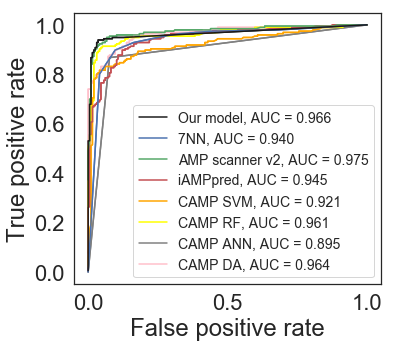

In [178]:
labels = [algorithm_names[i]+', AUC = '+'%.3f'%uniprot_roc_aucs[i] for i in range(len(uniprot_roc_aucs))]
colors = ['k','b','g','r','orange','yellow','gray','pink']
plt.figure(figsize=[5.5,5])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
# plt.plot([0,1],[0,1],'--',color='gray')
for i in range(len(uniprot_rocs)):
    plt.plot(uniprot_rocs[i][0],uniprot_rocs[i][1],'-',color=colors[i],label=labels[i])
for i in reversed(range(len(uniprot_rocs))):
    plt.plot(uniprot_rocs[i][0],uniprot_rocs[i][1],'-',color=colors[i])
plt.legend(loc=4,prop={'size':14})
plt.savefig('Figures_and_CNN_predictions/Uniprot_p9_roc_curves.png',bbox_inches='tight',frameon=False)
plt.show()

In [180]:
uniprot_fname = 'Figures_and_CNN_predictions/Saved_predictions/Uniprot_combined_predictions.xlsx'
uniprot_wkbk = xlrd.open_workbook(uniprot_fname)
uniprot_sheet = uniprot_wkbk.sheet_by_name('All_predictions')
y_true=[]
y_guesses = [[] for i in range(1,uniprot_sheet.ncols)]

for row_ind in range(1,uniprot_sheet.nrows):
    row = uniprot_sheet.row_values(row_ind)
    y_true_log_mic = row[0]
    if y_true_log_mic > 3.99:
        y_true.append(0)
    else:
        y_true.append(1)
    for col_ind in range(1,uniprot_sheet.ncols):
        if col_ind==1:
            y_guesses[col_ind-1].append(-row[col_ind])
        else:
            y_guesses[col_ind-1].append(row[col_ind])

uniprot_rocs = [roc_curve(y_true,y_guesses[i]) for i in range(len(y_guesses))]
uniprot_roc_aucs = [roc_auc_score(y_true,y_guesses[i]) for i in range(len(y_guesses))]
print (uniprot_roc_aucs)

[0.9730523170589677, 0.022277018967795312, 0.9742671716177846]


In [181]:
random_fname = 'Figures_and_CNN_predictions/Saved_predictions/Random_combined_p9_predictions.xlsx'
random_wkbk = xlrd.open_workbook(random_fname)
random_sheet = random_wkbk.sheet_by_name('All_predictions')
y_true=[]
y_guesses = [[] for i in range(1,random_sheet.ncols)]

for row_ind in range(1,random_sheet.nrows):
    row = random_sheet.row_values(row_ind)
    y_true_log_mic = row[0]
    if y_true_log_mic > 3.99:
        y_true.append(0)
    else:
        y_true.append(1)
    for col_ind in range(1,random_sheet.ncols):
        if col_ind==1:
            y_guesses[col_ind-1].append(-row[col_ind])
        else:
            y_guesses[col_ind-1].append(row[col_ind])

random_rocs = [roc_curve(y_true,y_guesses[i]) for i in range(len(y_guesses))]
random_roc_aucs = [roc_auc_score(y_true,y_guesses[i]) for i in range(len(y_guesses))]
print (random_roc_aucs)

[0.9729539775093712, 0.9703378800499792, 0.9615004164931279, 0.9106882548937942, 0.9459860474802165, 0.9693356934610577, 0.8928571428571428, 0.9740082257392755]


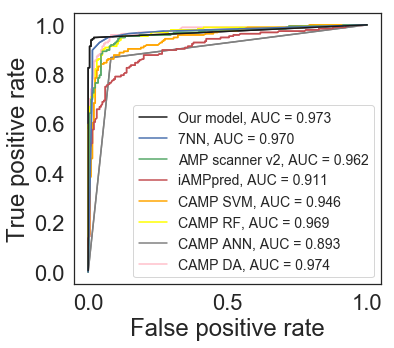

In [182]:
labels = [algorithm_names[i]+', AUC = '+'%.3f'%random_roc_aucs[i] for i in range(len(random_roc_aucs))]
colors = ['k','b','g','r','orange','yellow','gray','pink']
plt.figure(figsize=[5.5,5])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
# plt.plot([0,1],[0,1],'--',color='gray')
for i in range(len(random_rocs)):
    plt.plot(random_rocs[i][0],random_rocs[i][1],'-',color=colors[i],label=labels[i])
for i in reversed(range(len(random_rocs))):
    plt.plot(random_rocs[i][0],random_rocs[i][1],'-',color=colors[i])
plt.legend(loc=4,prop={'size':14})
plt.savefig('Figures_and_CNN_predictions/Random_p9_roc_curves.png',bbox_inches='tight',frameon=False)
plt.show()

In [183]:
random_fname = 'Figures_and_CNN_predictions/Saved_predictions/Random_combined_predictions.xlsx'
random_wkbk = xlrd.open_workbook(random_fname)
random_sheet = random_wkbk.sheet_by_name('All_predictions')
y_true=[]
y_guesses = [[] for i in range(1,random_sheet.ncols)]

for row_ind in range(1,random_sheet.nrows):
    row = random_sheet.row_values(row_ind)
    y_true_log_mic = row[0]
    if y_true_log_mic > 3.99:
        y_true.append(0)
    else:
        y_true.append(1)
    for col_ind in range(1,random_sheet.ncols):
        if col_ind==1 or col_ind==2:
            y_guesses[col_ind-1].append(-row[col_ind])
        else:
            y_guesses[col_ind-1].append(row[col_ind])

random_rocs = [roc_curve(y_true,y_guesses[i]) for i in range(len(y_guesses))]
random_roc_aucs = [roc_auc_score(y_true,y_guesses[i]) for i in range(len(y_guesses))]
print (random_roc_aucs)

[0.9794097212460994, 0.991236982984004, 0.9681848667274429]


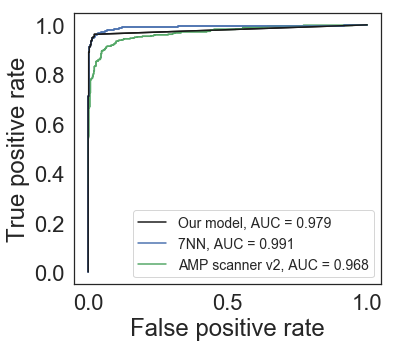

In [184]:
labels = [algorithm_names[i]+', AUC = '+'%.3f'%random_roc_aucs[i] for i in range(len(random_roc_aucs))]
colors = ['k','b','g','r','orange','yellow','gray']
plt.figure(figsize=[5.5,5])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
# plt.plot([0,1],[0,1],'--',color='gray')
for i in range(len(random_rocs)):
    plt.plot(random_rocs[i][0],random_rocs[i][1],'-',color=colors[i],label=labels[i])
for i in reversed(range(len(random_rocs))):
    plt.plot(random_rocs[i][0],random_rocs[i][1],'-',color=colors[i])
plt.legend(loc=4,prop={'size':14})
plt.savefig('Figures_and_CNN_predictions/Random_p9_roc_curves.png',bbox_inches='tight',frameon=False)
plt.show()

In [187]:
all_preds=[]
for emodel in ensemble_model_list:
    all_preds.append(emodel.predict(test_x_with_negatives))
output_file = open('Figures_and_CNN_predictions/predictions.csv','w')
output_file.write('Sequence,Amidation,Actual,No_C_1,No_C_3,No_C_10,With_C_1,With_C_3,With_C_10,All\n')
for i,testx in enumerate(test_x_with_negatives):
    amp = vector_to_amp(testx)
    output_file.write(repr(amp['sequence'])+','+repr(amp['cterminal_amidation'])+','+repr(test_y_with_negatives[i])+',')
    for k in range(len(ensemble_model_list)):
#         print all_preds
        output_file.write(repr(all_preds[k][i])+',')
    output_file.write('\n')
output_file.close()
seqs_for_fasta = []
for vect in test_x_with_negatives:
    seq = vector_to_amp(vect)['sequence']
    if seq.find('_')>-1:
        seq = seq[0:seq.find('_')]
    seqs_for_fasta.append(seq)
for_fasta = seqs_to_fasta(seqs_for_fasta)
test_file = open('data/Fasta_files/test_fasta_with_negatives.txt','w')
test_file.write(for_fasta)
test_file.close()

In [188]:
test_x_with_negatives_no_amidation = wipe_out_amidation(test_x_with_negatives)
all_preds=[]
for emodel in ensemble_model_list:
    all_preds.append(emodel.predict(test_x_with_negatives_no_amidation))
output_file = open('Figures_and_CNN_predictions/predictions_no_amidation.csv','w')
output_file.write('Sequence,Amidation,Actual,No_C_1,No_C_3,No_C_10,With_C_1,With_C_3,With_C_10,All\n')
for i,testx in enumerate(test_x_with_negatives_no_amidation):
    amp = vector_to_amp(testx)
    output_file.write(repr(amp['sequence'])+','+repr(amp['cterminal_amidation'])+','+repr(test_y_with_negatives[i])+',')
    for k in range(len(ensemble_model_list)):
#         print all_preds
        output_file.write(repr(all_preds[k][i])+',')
    output_file.write('\n')
output_file.close()

In [190]:
all_preds=[]
for emodel in ensemble_model_list:
    all_preds.append(emodel.predict(test_x_p9_with_negatives))
output_file = open('Figures_and_CNN_predictions/predictions_p9.csv','w')
output_file.write('Sequence,Amidation,Actual,No_C_1,No_C_3,No_C_10,With_C_1,With_C_3,With_C_10,All\n')
for i,testx in enumerate(test_x_p9_with_negatives):
    amp = vector_to_amp(testx)
    output_file.write(repr(amp['sequence'])+','+repr(amp['cterminal_amidation'])+','+repr(test_y_p9_with_negatives[i])+',')
    for k in range(len(ensemble_model_list)):
#         print all_preds
        output_file.write(repr(all_preds[k][i])+',')
    output_file.write('\n')
output_file.close()
seqs_for_fasta = []
for vect in test_x_p9_with_negatives:
    seq = vector_to_amp(vect)['sequence']
    if seq.find('_')>-1:
        seq = seq[0:seq.find('_')]
    seqs_for_fasta.append(seq)
for_fasta = seqs_to_fasta(seqs_for_fasta)
test_file = open('data/Fasta_files/test_fasta_with_negatives_p9.txt','w')
test_file.write(for_fasta)
test_file.close()

In [191]:
all_preds=[]
for emodel in ensemble_model_list:
    all_preds.append(emodel.predict(test_x_p7_with_negatives))
output_file = open('Figures_and_CNN_predictions/predictions_p7.csv','w')
output_file.write('Sequence,Amidation,Actual,No_C_1,No_C_3,No_C_10,With_C_1,With_C_3,With_C_10,All\n')
for i,testx in enumerate(test_x_p7_with_negatives):
    amp = vector_to_amp(testx)
    output_file.write(repr(amp['sequence'])+','+repr(amp['cterminal_amidation'])+','+repr(test_y_p7_with_negatives[i])+',')
    for k in range(len(ensemble_model_list)):
#         print all_preds
        output_file.write(repr(all_preds[k][i])+',')
    output_file.write('\n')
output_file.close()
seqs_for_fasta = []
for vect in test_x_p7_with_negatives:
    seq = vector_to_amp(vect)['sequence']
    if seq.find('_')>-1:
        seq = seq[0:seq.find('_')]
    seqs_for_fasta.append(seq)
for_fasta = seqs_to_fasta(seqs_for_fasta)
test_file = open('data/Fasta_files/test_fasta_with_negatives_p7.txt','w')
test_file.write(for_fasta)
test_file.close()

# Regression performance

In [192]:
all_predicted = everything_ensemble_model_avg.predict(test_x)
p7_predicted = everything_ensemble_model_avg.predict(test_x_p7)
p9_predicted = everything_ensemble_model_avg.predict(test_x_p9)

In [193]:
def evaluate_predictions(predicted,test_y):
    tau,pval = kendalltau(predicted,test_y)
    mse = 'MSE,'+repr(float(np.average([(predicted[i]-test_y[i])**2 for i in range(len(test_y))])))
    pearson = 'Pearson,'+repr(float(np.corrcoef(predicted,test_y)[1,0]))
    tau = 'Kendall tau,'+repr(tau)
    print mse+','+pearson+','+tau+','

In [194]:
evaluate_predictions(all_predicted,test_y)
evaluate_predictions(p9_predicted,test_y_p9)
evaluate_predictions(p7_predicted,test_y_p7)

MSE,0.1647437306054314,Pearson,0.872911765811065,Kendall tau,0.7948062132658779,
MSE,1.3610767075739303,Pearson,0.5496915988941103,Kendall tau,0.5010111233785013,
MSE,2.1603115020335273,Pearson,0.3977667986956785,Kendall tau,0.326362689414732,


In [195]:
print np.corrcoef(all_predicted,test_y)
print np.corrcoef(p9_predicted,test_y_p9)
print np.corrcoef(p7_predicted,test_y_p7)

[[1.         0.87291177]
 [0.87291177 1.        ]]
[[1.        0.5496916]
 [0.5496916 1.       ]]
[[1.        0.3977668]
 [0.3977668 1.       ]]


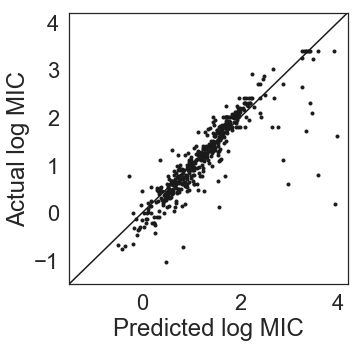

In [197]:
# plt.set(font_scale=1,style='white',font='Arial')
font_to_use = {'fontname':FONT_TO_USE}
f, ax = plt.subplots(figsize=(5,5))
plt.plot(all_predicted,test_y,'.',color='k')
plt.plot([-2,4.2],[-2,4.2],'k-')
plt.ylim(-1.5,4.2)
plt.xlim(-1.5,4.2)
plt.xlabel('Predicted log MIC',**font_to_use)
plt.ylabel('Actual log MIC',**font_to_use)
for tick in ax.get_xticklabels():
    tick.set_fontname(FONT_TO_USE)
for tick in ax.get_yticklabels():
    tick.set_fontname(FONT_TO_USE)
plt.tick_params(top='off',right='off')
plt.savefig('Figures_and_CNN_predictions/pred_vs_actual_all.png',bbox_inches='tight',frameon=False)
plt.show()

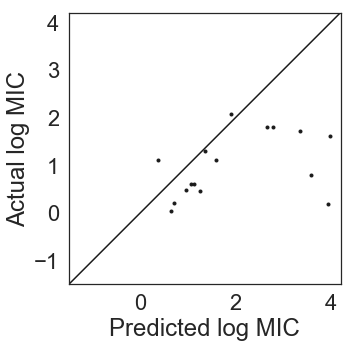

In [198]:
font_to_use = {'fontname':FONT_TO_USE}
f, ax = plt.subplots(figsize=(5,5))
plt.plot(p7_predicted,test_y_p7,'k.')
plt.plot([-2,4.2],[-2,4.2],'k-')
plt.xlabel('Predicted log MIC',**font_to_use)
plt.ylabel('Actual log MIC',**font_to_use)
plt.ylim(-1.5,4.2)
plt.xlim(-1.5,4.2)
for tick in ax.get_xticklabels():
    tick.set_fontname(FONT_TO_USE)
for tick in ax.get_yticklabels():
    tick.set_fontname(FONT_TO_USE)
plt.tick_params(top='off',right='off')
ax.set_aspect('equal')
plt.savefig('Figures_and_CNN_predictions/pred_vs_actual_p7.png',bbox_inches='tight',frameon=False)
plt.show()

In [199]:
len(p7_predicted)

16

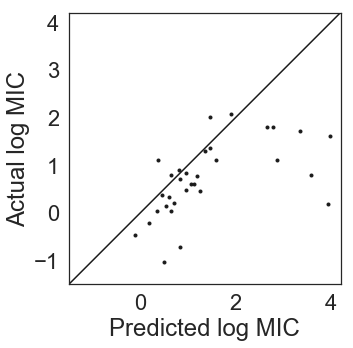

In [200]:
font_to_use = {'fontname':FONT_TO_USE}
f, ax = plt.subplots(figsize=(5,5))
plt.plot(p9_predicted,test_y_p9,'k.')
plt.plot([-2,4.2],[-2,4.2],'k-')
plt.xlabel('Predicted log MIC',**font_to_use)
plt.ylabel('Actual log MIC',**font_to_use)
plt.ylim(-1.5,4.2)
plt.xlim(-1.5,4.2)
for tick in ax.get_xticklabels():
    tick.set_fontname(FONT_TO_USE)
for tick in ax.get_yticklabels():
    tick.set_fontname(FONT_TO_USE)
plt.tick_params(top='off',right='off')
ax.set_aspect('equal')
plt.savefig('Figures_and_CNN_predictions/pred_vs_actual_p9.png',bbox_inches='tight',frameon=False)
plt.show()